<p style="font-size:36px;text-align:center"> <b> Product Backorder Prediction </b> </p>

In [150]:
#import rarfile
import patoolib
import numpy as np,seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import scipy.stats as stats
from fitter import Fitter, get_common_distributions, get_distributions
import missingno as msno
from prettytable import PrettyTable
from collections import Counter
#import dill
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
import imblearn
import imblearn.over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from plotly import tools
from plotly.subplots import make_subplots
from plotly.offline import iplot
import pandas as pd

<h3> Reading data to train the models</h3>

In [ ]:
# reading binned and non-binned data

train_df = pd.read_csv('X_train.csv')
test_df = pd.read_csv('X_test.csv')

train_df_binned = pd.read_csv('binned_feats_train.csv')
test_df_binned = pd.read_csv('binned_feats_test.csv')

y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [146]:
#binned data doesn't contain categorical features, adding categorical features to binned data
train_df_binned[['deck_risk', 'oe_constraint','ppap_risk', 'stop_auto_buy', 'rev_stop','pieces_past_due','local_bo_qty','potential_issue']] =  train_df[['deck_risk', 'oe_constraint',\
        'ppap_risk', 'stop_auto_buy', 'rev_stop','pieces_past_due','local_bo_qty','potential_issue']]
test_df_binned[['deck_risk', 'oe_constraint','ppap_risk', 'stop_auto_buy', 'rev_stop','pieces_past_due','local_bo_qty','potential_issue']] =  test_df[['deck_risk', 'oe_constraint',\
        'ppap_risk', 'stop_auto_buy', 'rev_stop','pieces_past_due','local_bo_qty','potential_issue']]

#train_df_binned.drop('went_on_backorder',axis=1,inplace = True)
#test_df_binned.drop('went_on_backorder',axis = 1,inplace = True)

#train_df.drop(['went_on_backorder'],inplace = True, axis = 1)
#test_df.drop(['inv_tree'],inplace = True, axis = 1)

In [171]:
y_train = y_train['went_on_backorder']
y_test = y_test['went_on_backorder']

<h2>Constructing Machine Learning Models</h2>

#### implementing some useful functions

In [147]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("indigo")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [148]:
def find_best_threshold(threshold, fpr, tpr):

    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [215]:
def plot_AUC(train_pred,test_pred,y = y_train,y_test_ = y_test ):
    #calulates the roc-auc & pr-auc scores and plots the AUC, confusion matrix
    
    fpr_test,tpr_test,thresholds_test = roc_curve(y_true=y_test_,y_score=test_pred[:,1])
    fpr_train,tpr_train,thresholds_train = roc_curve(y_true=y,y_score=train_pred[:,1])

    precision_train, recall_train, _ = precision_recall_curve(y, train_pred[:,1])
    precision_test, recall_test, _ = precision_recall_curve(y_test_, test_pred[:,1])

    print('Train ROC-AUC score for best alpha-value::',round(auc(fpr_train,tpr_train),3),'\n')
    print('Test ROC-AUC score for best alpha-value::',round(auc(fpr_test,tpr_test),3),'\n')

    print('\nTrain PR-AUC score for best alpha-value:: ',round(auc(recall_train, precision_train),3))
    print('Test PR-AUC score for best alpha-value:: ',round(auc(recall_test, precision_test),3))
    

    plt.figure(figsize=(16,6))

    plt.subplot(121)
    plt.title("ROC-AUC plot")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot(fpr_train,tpr_train,label = 'train-data')
    plt.plot(fpr_test,tpr_test,label = 'test-data')
    plt.legend()

    plt.subplot(122)
    plt.title("PR-AUC plot")
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.plot(recall_train,precision_train,label = 'train-data')
    plt.plot(recall_test,precision_test,label = 'test-data')
    plt.legend()

    plt.show()
    
    best_t = find_best_threshold(thresholds_train, fpr_train, tpr_train)
    train_pred = predict_with_best_t(train_pred[:,1], best_t)
    test_pred = predict_with_best_t(test_pred[:,1], best_t)
    
    print('\n')
    
    print('-'*30)
    print('Classification Report:Train')
    print('-'*30)
    print(classification_report(y,train_pred))
    print('\n')
    print('-'*30)
    print('Classification Report:Test')
    print('-'*30)
    print(classification_report(y_test_,test_pred))
    
    
    print('\n\t\t\t#####','TRAIN CONFUSION MATRIX','#####')
    plot_confusion_matrix(y, train_pred)
    print('\t\t\t#####','TEST CONFUSION MATRIX','#####')
    plot_confusion_matrix(y_test_,test_pred)

In [152]:
def gridSearch(df,clf,params):
    #performs grid search on classifier passed
    gd = GridSearchCV(cv=3,estimator=clf,param_grid=params,return_train_score=True,scoring='roc_auc',n_jobs=-1)
    gd.fit(df,y_train);

    print('BEST-PARAMS:::\t',gd.best_params_)
    print('BEST-SCORE:::\t',gd.best_score_)
    return gd.best_params_


In [153]:
def model_interpretabiltiy(df,test_pred,feat_imp):
    #plots feature imortances of a model
    plt.figure(figsize=(12,8))
    plt.bar(range(len(df.columns)),feat_imp.values())
    plt.xlabel('FEATURE')
    plt.ylabel('WEIGHT')
    plt.title('FEATURE IMPORTANCES',color = 'red',fontdict={'fontsize':14})
    for i, feat,imp in zip(range(len(feat_imp.keys())),feat_imp.keys(),feat_imp.values()):
        plt.text(i ,imp  , str(feat), color='k', fontstyle='italic',rotation = 90)
    plt.show()

In [155]:
#stanadrdizing data
from sklearn.preprocessing import scale

scaler = StandardScaler()

train_df_std = scaler.fit_transform(train_df.select_dtypes('number').drop(['deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop','potential_issue'],axis = 1))
test_df_std = scaler.transform(test_df.select_dtypes('number').drop(['deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop','potential_issue'],axis = 1))

train_df_std = np.hstack((train_df_std,train_df[['deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop','potential_issue']]))
test_df_std = np.hstack((test_df_std,test_df[['deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop','potential_issue']]))

<h4> Building Random Model to find the worst AUC score</h4>

AUC score under roc curve for the worst model: 0.493
AUC score under precision-recall curve for the worst model: 0.010


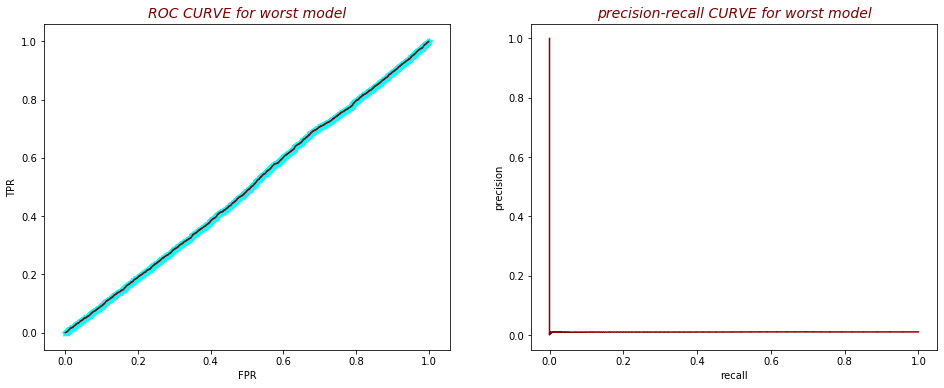

-------------------------
Classification Report:
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.50      0.66    268808
           1       0.01      0.49      0.02      2807

    accuracy                           0.50    271615
   macro avg       0.50      0.49      0.34    271615
weighted avg       0.98      0.50      0.66    271615



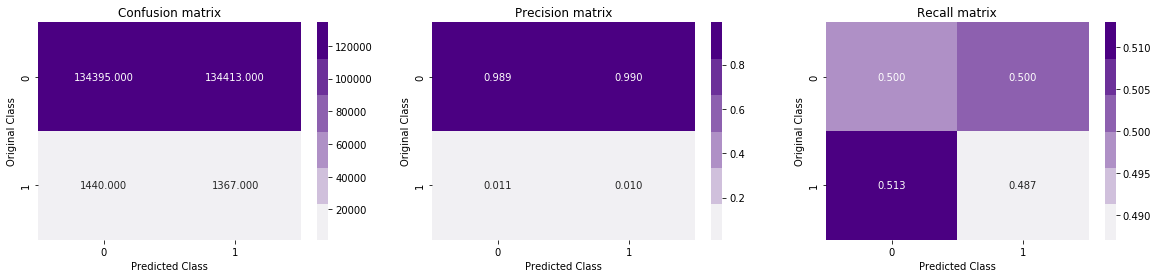

In [165]:
predicted_y = np.zeros((y_test.shape[0],2))
for i in range(y_test.shape[0]):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    

pos_probs = predicted_y[:, 1]
# calculate the precision-recall auc
fpr, tpr, _ = roc_curve(y_test, pos_probs)
auc_score = roc_auc_score(y_test, pos_probs)
print('AUC score under roc curve for the worst model: %.3f' % auc_score)

precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('AUC score under precision-recall curve for the worst model: %.3f' % auc_score)


plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(fpr,tpr,color = 'darkred')
plt.scatter(fpr,tpr,color = 'cyan',marker = '*')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC CURVE for worst model',color = 'maroon',fontdict={'fontsize':14,'fontstyle':'oblique'})

plt.subplot(122)
plt.plot(recall,precision,color = 'darkred')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall CURVE for worst model',color = 'maroon',fontdict={'fontsize':14,'fontstyle':'oblique'})
plt.show()


predicted_y =np.argmax(predicted_y, axis=1)
print('-'*25)
print('Classification Report:')
print('-'*25)
print(classification_report(y_test,predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<font color = 'green'>
    <b>
        <i>
- A model which randomly predicts datapoints as +ve and -ve gives a ROC-AUC score of 0.5, this means that when we pass a datapoint to this model, there is 50% chance of correctly classifying the datapoint to its corresponding class label. 50% probablity is way too less, so the models that we build must give an AUC score much more than 0.5 to consider it to be a good model.

<h2> 1. Training Logit model on the data </h2>

<h3> 1.1. Trianing Logistic Regression on non-binned features</h3> 

In [166]:
%%time
clf_LR = LogisticRegression()
params = {'C':[10 ** x for x in range(-5, 4)],'penalty':['l1','l2'],'class_weight':[{0:0.1,1:0.9},{0:0.2,1:0.8},'balanced']}
gd = GridSearchCV(cv=3,estimator=clf_LR,param_grid=params,return_train_score=True,scoring='roc_auc',n_jobs=-1)
gd.fit(train_df_std,y_train);

results = pd.DataFrame.from_dict(gd.cv_results_)
results = results.sort_values(['param_C'])

print('BEST-PARAMS:::\t',gd.best_params_)
print('BEST-SCORE:::\t',gd.best_score_)

BEST-PARAMS:::	 {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2'}
BEST-SCORE:::	 0.9015812762165338
CPU times: user 10.2 s, sys: 852 ms, total: 11 s
Wall time: 5min 44s


Train ROC-AUC score for best alpha-value:: 0.902 

Test ROC-AUC score for best alpha-value:: 0.901 


Train PR-AUC score for best alpha-value::  0.089
Test PR-AUC score for best alpha-value::  0.091


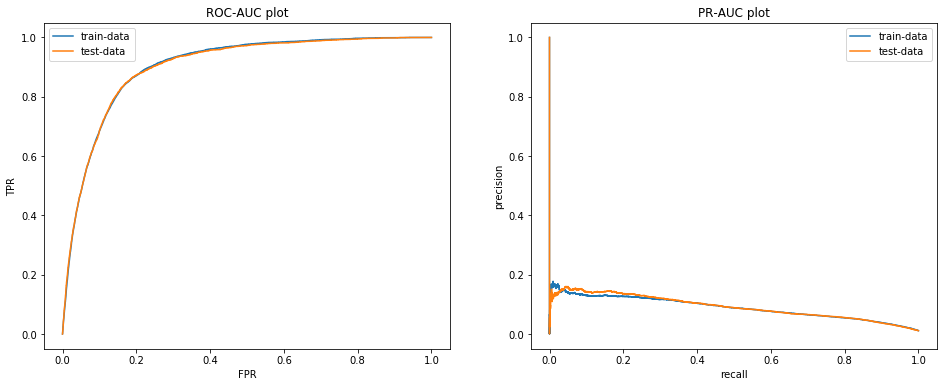

the maximum value of tpr*(1-fpr) 0.7006778467639185 for threshold 0.015


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    627216
           1       0.05      0.86      0.09      6550

    accuracy                           0.81    633766
   macro avg       0.52      0.84      0.49    633766
weighted avg       0.99      0.81      0.89    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    268808
           1       0.05      0.87      0.09      2807

    accuracy                           0.81    271615
   macro avg       0.52      0.84      0.49    271615
weighted avg       0.99      0.81      0.89    271615


			##### TRAIN CONFUSION MATRIX #####


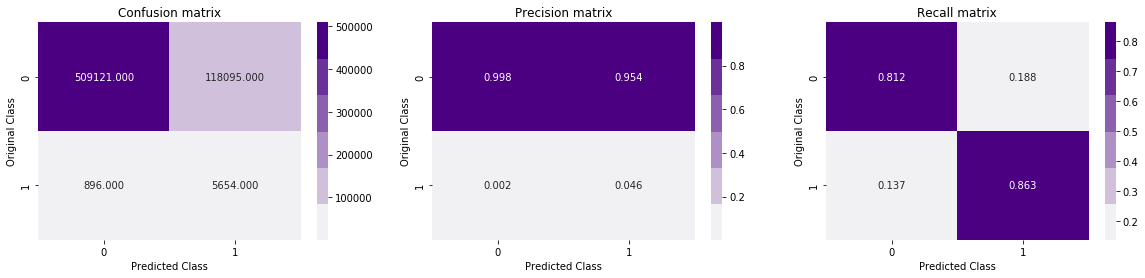

			##### TEST CONFUSION MATRIX #####


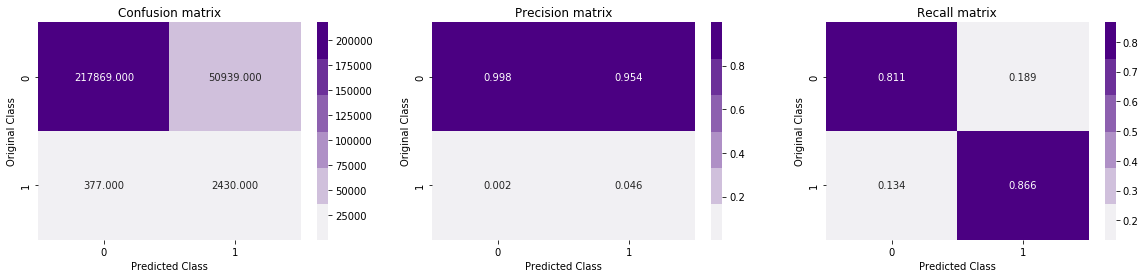

CPU times: user 55.4 s, sys: 424 ms, total: 55.9 s
Wall time: 58.1 s


In [181]:
%%time
logisticR=LogisticRegression(penalty=gd.best_params_['penalty'],C=gd.best_params_['C'],class_weight=gd.best_params_['class_weight'])
logisticR.fit(train_df_std,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(train_df_std, y_train)

train_pred = sig_clf.predict_proba(train_df_std)
test_pred = sig_clf.predict_proba(test_df_std)

plot_AUC(train_pred,test_pred)

<font color = 'green'>
    <b><i>
        
- Training Logistic Regression model on the continuos data yeilded ROC-AUC of 0.90 on both train data and test data which is a good score. So the model is doing a good job in seperating out Backorders from non-backorders, but if we look at the PR-AUC scores, train data has a PR-AUC of 0.089 and test data has a PR-AUC of 0.091 which is a very poor score and is due to the reason of model predicting some False positives.
        
        
        
- If we observe the confusion matrices and Classification report of test data, we observe that the recall is 0.866 which is actually a good score but the precision score on postive points is 0.05 which is a very less score. The reason for this is, total no.of True positives predicted by the model are 53369 and among them 50939 are False positive so due to this the precision of the model has decresed significantly which in turn yeilded a very low PR-AUC score.
        
        
        
- The f1-score of the negative points is 0.89 which is a good score but for the positive points the f1-score is 0.09 which is a poor score caused by false positives predicted by the model.


- Model seems to have a problem of predicting false positives.

FEATURE IMPORTANCE:
-------------------- 

national_inv	: -11.51893
lead_time	: 1.02174
in_transit_qty	: -2.53739
forecast_3_month	: -0.83088
forecast_6_month	: -0.86973
forecast_9_month	: 0.2068
sales_1_month	: 1.23868
sales_3_month	: 0.84389
sales_6_month	: 0.21079
sales_9_month	: 0.1002
min_bank	: -0.57774
potential_issue	: -0.25364
pieces_past_due	: -0.20587
perf_6_month_avg	: -0.05267
perf_12_month_avg	: -0.45014
local_bo_qty	: 0.60637
deck_risk	: -0.44399
oe_constraint	: -0.11319
ppap_risk	: -11.67725
stop_auto_buy	: -0.1726
rev_stop	: 0.20438
sales_1to3	: 0.39787
sales_3to6	: -0.37604
sales_6to9	: -0.09352
min_bank_error	: -0.69121
forecast_error	: 10.79215
perf_diff	: -0.42293
leadtime_demand	: 0.55364
reorder_point	: 0.09848
weighted_sales	: -0.62201
pc1	: -0.46022
pc2	: 1.21544


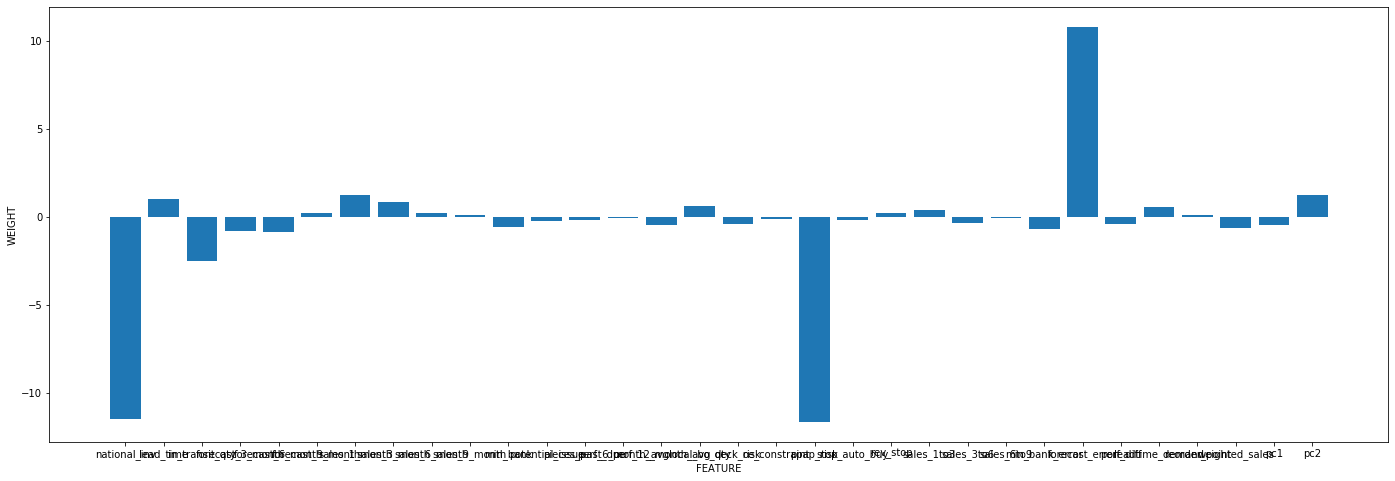

In [182]:
print('FEATURE IMPORTANCE:')
print('-'*20,'\n')
for column,importance in zip(train_df.columns,logisticR.coef_[0]):
    print(column+'\t:',round(importance,5))
    
plt.figure(figsize=(24,8))
plt.bar(train_df.columns,logisticR.coef_[0])
plt.xlabel('FEATURE')
plt.ylabel('WEIGHT')
plt.show();

<font color = 'green'>
<b>
<i>
    
    
- Based on the above plot of feature importances, forecast error seems to be the imortant feature in predicting backorders and ppap_risk & national_inve seems to be important in predicting non-backordedrs.
    

<h3> 1.2. Training Logistic Regression on binned features</h3> 

In [183]:
%%time
best_params = gridSearch(train_df_binned,LogisticRegression(penalty='l2'),{'C':[10 ** x for x in range(-5, 4)],'class_weight':[{0:0.1,1:0.9},{0:0.2,1:0.8},'balanced']})

BEST-PARAMS:::	 {'C': 0.1, 'class_weight': 'balanced'}
BEST-SCORE:::	 0.8964984740847183
CPU times: user 10.8 s, sys: 844 ms, total: 11.6 s
Wall time: 8min 33s


Train ROC-AUC score for best alpha-value:: 0.897 

Test ROC-AUC score for best alpha-value:: 0.893 


Train PR-AUC score for best alpha-value::  0.115
Test PR-AUC score for best alpha-value::  0.095


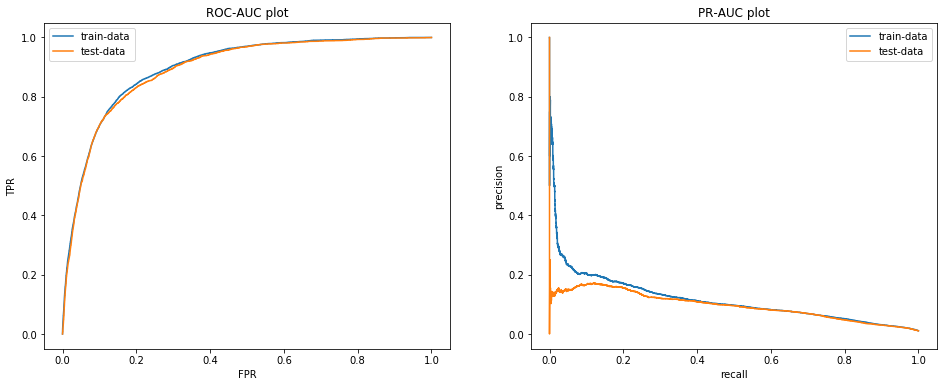

the maximum value of tpr*(1-fpr) 0.678946857076983 for threshold 0.01


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    627216
           1       0.05      0.82      0.09      6550

    accuracy                           0.83    633766
   macro avg       0.52      0.82      0.50    633766
weighted avg       0.99      0.83      0.90    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    268808
           1       0.05      0.80      0.09      2807

    accuracy                           0.83    271615
   macro avg       0.52      0.82      0.50    271615
weighted avg       0.99      0.83      0.90    271615


			##### TRAIN CONFUSION MATRIX #####


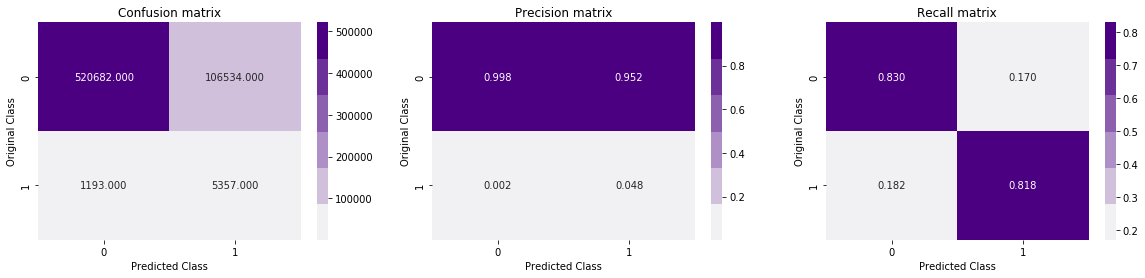

			##### TEST CONFUSION MATRIX #####


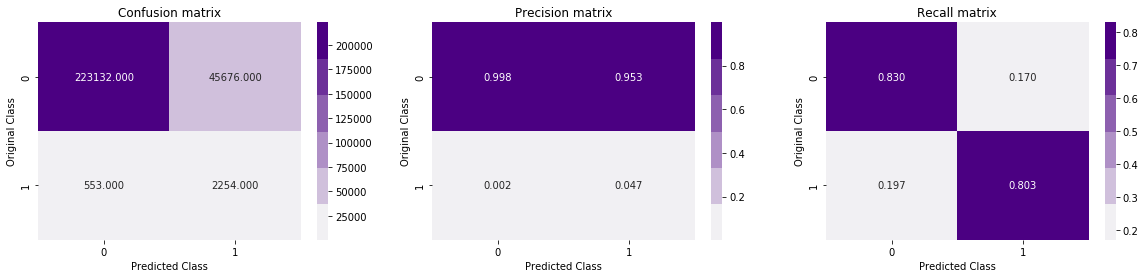

CPU times: user 54.3 s, sys: 300 ms, total: 54.6 s
Wall time: 1min 12s


In [184]:
%%time
logisticR=LogisticRegression(penalty='l2',C=best_params['C'],class_weight=best_params['class_weight'])
logisticR.fit(train_df_binned,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(train_df_binned, y_train)

train_pred = sig_clf.predict_proba(train_df_binned)
test_pred = sig_clf.predict_proba(test_df_binned)

plot_AUC(train_pred,test_pred)

FEATURE IMPORTANCE:
-------------------- 

national_inv_tree	: 17.81732
lead_time_tree	: 3.39091
in_transit_qty_tree	: 4.52395
forecast_3_month_tree	: 17.48789
forecast_6_month_tree	: 15.47102
forecast_9_month_tree	: 13.63514
sales_1_month_tree	: 5.81824
sales_3_month_tree	: 6.68954
sales_6_month_tree	: 6.03277
sales_9_month_tree	: 5.45959
min_bank_tree	: 2.38329
perf_6_month_avg_tree	: 6.17472
perf_12_month_avg_tree	: 5.33914
sales_1to3_tree	: 4.60503
sales_3to6_tree	: 3.22504
sales_6to9_tree	: 2.80945
min_bank_error_tree	: 25.07215
forecast_error_tree	: 10.842
perf_diff_tree	: 2.41627
leadtime_demand_tree	: 6.6555
pc1_tree	: 9.03969
pc2_tree	: 17.95533
deck_risk	: -0.14885
oe_constraint	: 2.43053
ppap_risk	: -0.04966
stop_auto_buy	: 0.14088
rev_stop	: -0.55101
pieces_past_due	: 0.00827
local_bo_qty	: -0.00615
potential_issue	: -1.24031


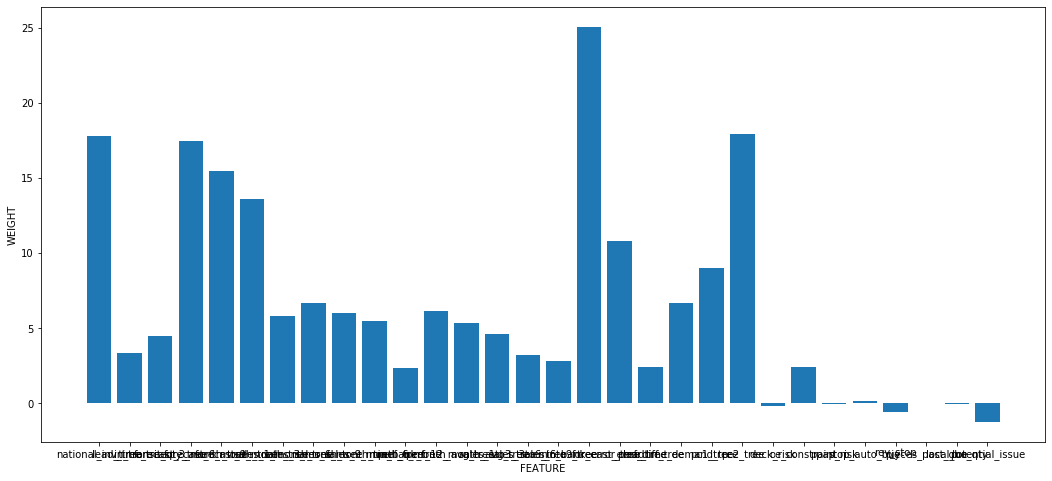

In [185]:
print('FEATURE IMPORTANCE:')
print('-'*20,'\n')
for column,importance in zip(train_df_binned.columns,logisticR.coef_[0]):
    print(column+'\t:',round(importance,5))
    
plt.figure(figsize=(18,8))
plt.bar(train_df_binned.columns,logisticR.coef_[0])
plt.xlabel('FEATURE')
plt.ylabel('WEIGHT')
plt.show();

feat_imp = dict(zip(train_df_binned.columns,logisticR.coef_[0]))

<font color = 'green'>
<b>
<i>

- ROC-AUC of Logit models when tranied on Binned data slightly decreased compared to the ROC-AUC on non-binned data, but PR-AUC has improved slightly on both train data and test data.
  
    
- F1-score on negaitve data points have imporved slightly but the F1-score on positive datapoints still is the same.
    
    
- We can observe that for the best threshold value both recall and precision of logit on binned data has decreased
compared to that of non-binned data.
 
    
- Binning the features doesn't seem to be useful in the case of logit mode.
    
    
- Almost all the features appear to be important for predicting backorders, only features potential_issue and rev_stop seem to be important in predicting non-backorders.

<h2>2.Training Decision Tree on the data</h2>

<h3>2.1. Training Decision Tree on non-binned data </h3> 

BEST-PARAMS:::	 {'class_weight': {0: 0.2, 1: 0.8}, 'max_depth': 10, 'min_samples_split': 1000}
BEST-SCORE:::	 0.916138276748948
Train ROC-AUC score for best alpha-value:: 0.95 

Test ROC-AUC score for best alpha-value:: 0.934 


Train PR-AUC score for best alpha-value::  0.231
Test PR-AUC score for best alpha-value::  0.21


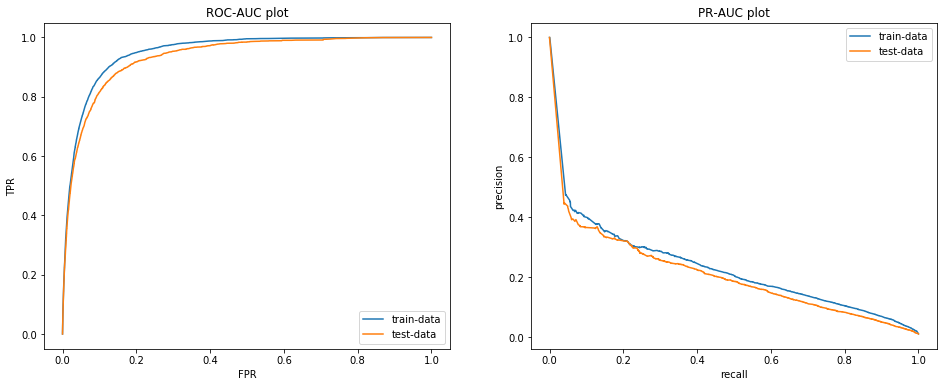

the maximum value of tpr*(1-fpr) 0.7877127126761645 for threshold 0.007


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    627216
           1       0.07      0.90      0.13      6550

    accuracy                           0.87    633766
   macro avg       0.53      0.89      0.53    633766
weighted avg       0.99      0.87      0.92    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    268808
           1       0.07      0.86      0.12      2807

    accuracy                           0.87    271615
   macro avg       0.53      0.86      0.53    271615
weighted avg       0.99      0.87      0.92    271615


			##### TRAIN CONFUSION MATRIX #####


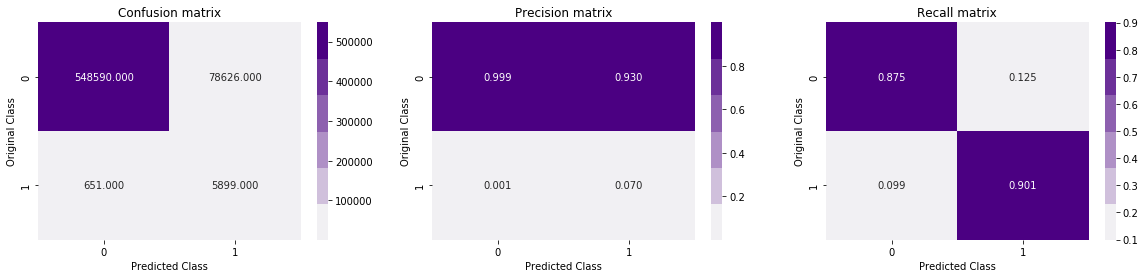

			##### TEST CONFUSION MATRIX #####


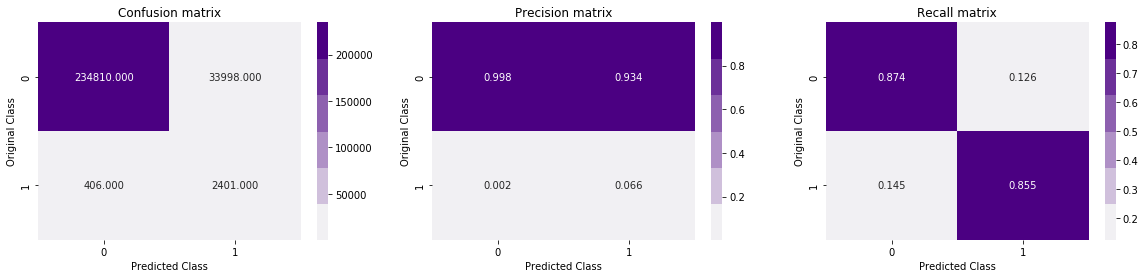

CPU times: user 1min 27s, sys: 512 ms, total: 1min 28s
Wall time: 12min 21s


In [186]:
%%time

best_params = gridSearch(train_df,DecisionTreeClassifier(),{'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500,1000],'class_weight':[{0:0.1,1:0.9},{0:0.2,1:0.8},'balanced']})
clf_dt = DecisionTreeClassifier(max_depth=best_params['max_depth'],min_samples_split=best_params['min_samples_split'],\
                                class_weight=best_params['class_weight'])
clf_dt.fit(train_df,y_train)
calib_clf_dt = CalibratedClassifierCV(clf_dt,method="sigmoid")
calib_clf_dt.fit(train_df, y_train)

train_pred = calib_clf_dt.predict_proba(train_df)
test_pred = calib_clf_dt.predict_proba(test_df)

plot_AUC(train_pred,test_pred)

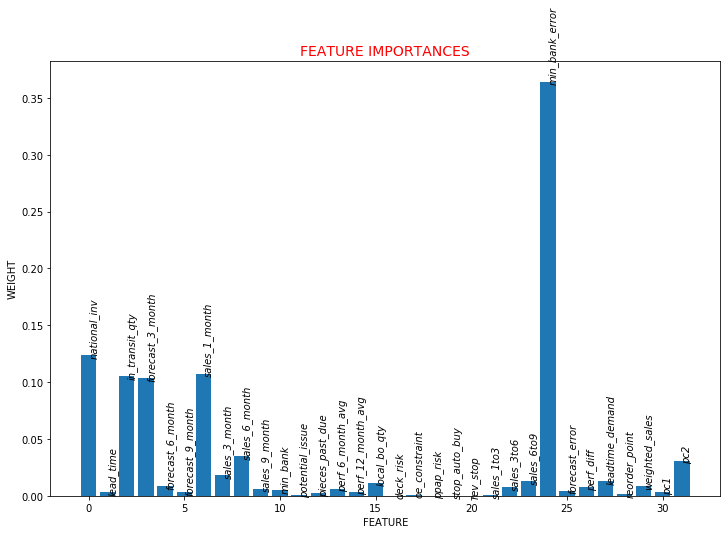

In [187]:
dt_feat_imp = dict(zip(train_df.columns,np.round(clf_dt.feature_importances_,4)))
model_interpretabiltiy(train_df,test_pred,dt_feat_imp)

<font color = 'green'>
    <b>
        <i>
            
- Training a decision tree model on continuos data gave an ROC-AUC of 0.93 and PR-AUC of ~0.21  on test data, both ROC-AUC and PR-AUC have improved significantly. Recall on test data has also improved to ~0.86 but precision still is very low.
            

- F1-score on both the positive datapoints and negative datapoints have been improved compared to that of logit model.
            
            
- Decision tree also has a problem of predicting false positives which is causeing low precision score.
            
            
- Features min_bank_error seems to be most important for the model in calssifying backorders from non-backorders. Also the features current inventory,in_transit_qty,forecast_3_month and sales in first month appear to be important for the model in predicting backorders.
 
            
- Training a single Decision tree yielded an ROC-AUC score of 0.934 and PR-AUC of 0.21 which is a good score, if we train ensembles on the data the AUC score might improve much further leading in better classsification of backorders.

<h3> 2.2. Training Decision Tree on binned data </h3> 

BEST-PARAMS:::	 {'class_weight': {0: 0.2, 1: 0.8}, 'max_depth': 10, 'min_samples_split': 1000}
BEST-SCORE:::	 0.9138087187863325
Train ROC-AUC score for best alpha-value:: 0.938 

Test ROC-AUC score for best alpha-value:: 0.921 


Train PR-AUC score for best alpha-value::  0.22
Test PR-AUC score for best alpha-value::  0.181


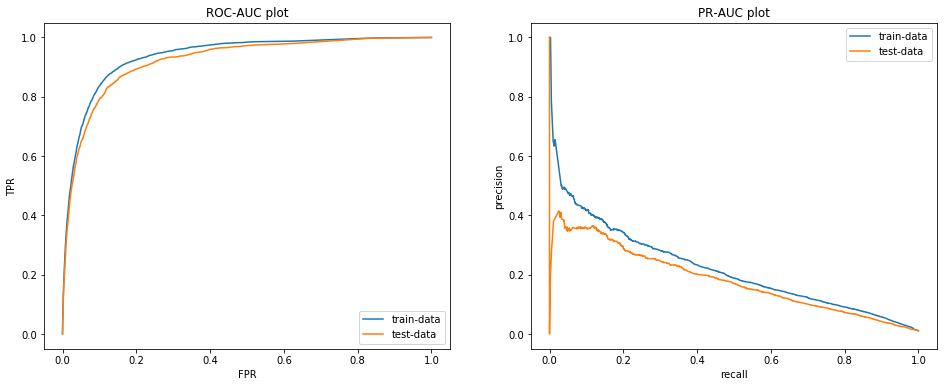

the maximum value of tpr*(1-fpr) 0.7651138926098435 for threshold 0.007


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    627216
           1       0.07      0.88      0.13      6550

    accuracy                           0.87    633766
   macro avg       0.53      0.87      0.53    633766
weighted avg       0.99      0.87      0.92    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    268808
           1       0.06      0.84      0.12      2807

    accuracy                           0.87    271615
   macro avg       0.53      0.85      0.53    271615
weighted avg       0.99      0.87      0.92    271615


			##### TRAIN CONFUSION MATRIX #####


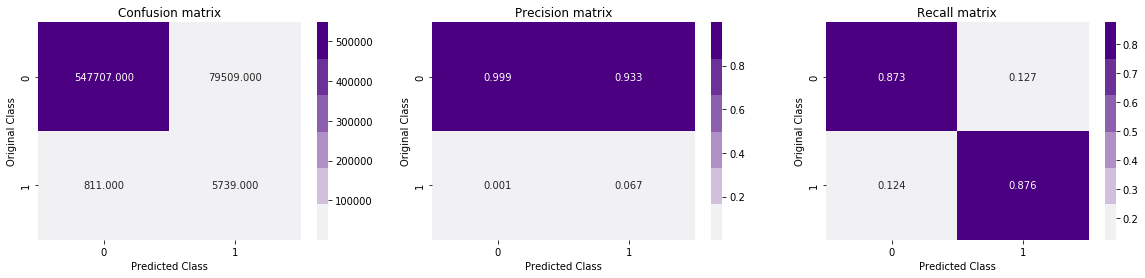

			##### TEST CONFUSION MATRIX #####


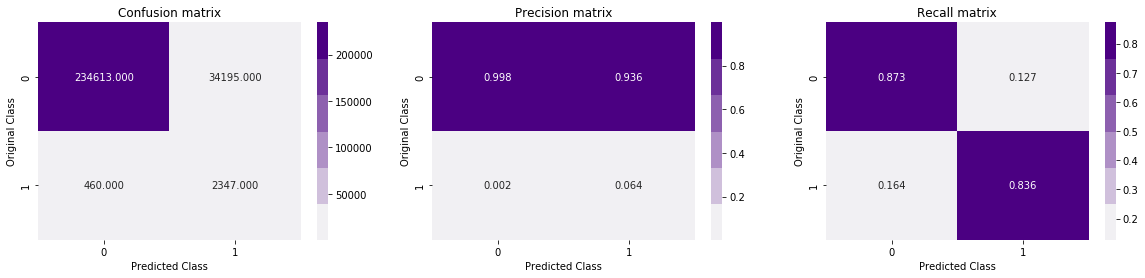

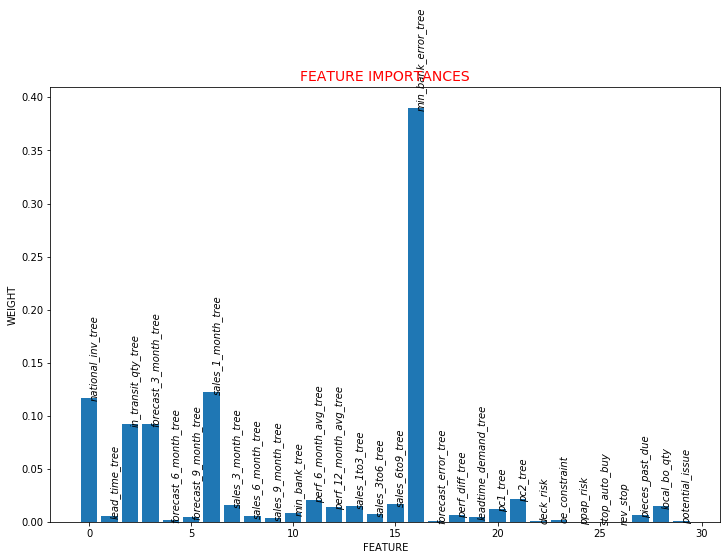

In [230]:
%%time

best_params = gridSearch(train_df_binned,DecisionTreeClassifier(),{'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500,1000],'class_weight':[{0:0.1,1:0.9},{0:0.2,1:0.8},'balanced']})
clf_dt = DecisionTreeClassifier(max_depth=best_params['max_depth'],min_samples_split=best_params['min_samples_split'],\
                                class_weight=best_params['class_weight'])
clf_dt.fit(train_df_binned,y_train)
calib_clf_dt = CalibratedClassifierCV(clf_dt,method="sigmoid")
calib_clf_dt.fit(train_df_binned, y_train)

train_pred = calib_clf_dt.predict_proba(train_df_binned)
test_pred = calib_clf_dt.predict_proba(test_df_binned)

plot_AUC(train_pred,test_pred)

dt_feat_imp = dict(zip(train_df_binned.columns,np.round(clf_dt.feature_importances_,4)))
model_interpretabiltiy(train_df_binned,test_pred,dt_feat_imp)

<font color = 'green'>
    <b>
        <i>

-  Similar to the logit model when a decision tree is trained on binned data all the scores ROC-AUC, PR-AUC, f1-score, precision and recall have decreased. Binning data doesn't seem to improve the model's performance even for a decision tree.

            
- Feature importance appears to be the same as non-binned data.

<h2>3. Training Random forest on data</h2>

<h3>3.1 Training Random Forest non-binned data </h3>

BEST-PARAMS:::	 {'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 15, 'n_estimators': 200}
BEST-SCORE:::	 0.9585825215957308
Train ROC-AUC score for best alpha-value:: 0.997 

Test ROC-AUC score for best alpha-value:: 0.965 


Train PR-AUC score for best alpha-value::  0.828
Test PR-AUC score for best alpha-value::  0.394


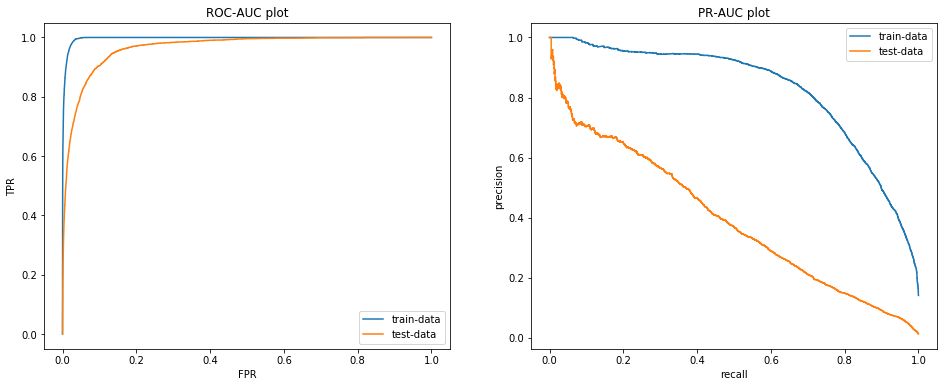

the maximum value of tpr*(1-fpr) 0.9596034296523438 for threshold 0.014


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    627216
           1       0.23      0.99      0.38      6550

    accuracy                           0.97    633766
   macro avg       0.62      0.98      0.68    633766
weighted avg       0.99      0.97      0.98    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    268808
           1       0.17      0.77      0.27      2807

    accuracy                           0.96    271615
   macro avg       0.58      0.87      0.63    271615
weighted avg       0.99      0.96      0.97    271615


			##### TRAIN CONFUSION MATRIX #####


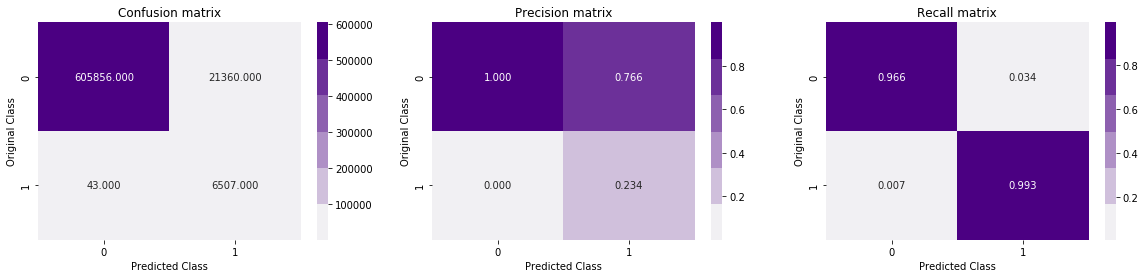

			##### TEST CONFUSION MATRIX #####


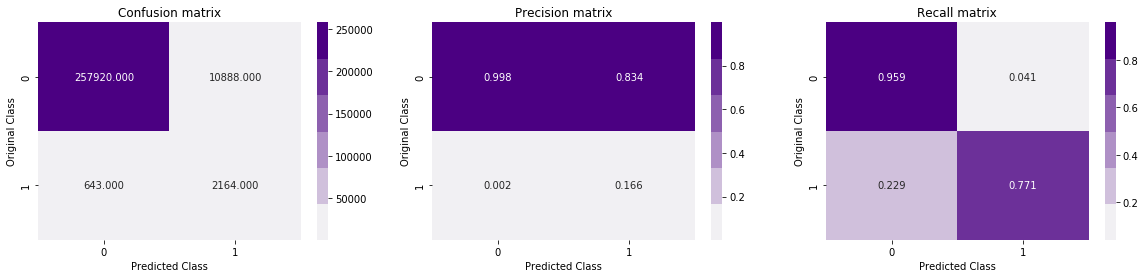

CPU times: user 32min 2s, sys: 1.85 s, total: 32min 4s
Wall time: 2h 3min 48s


In [189]:
%%time

best_params = gridSearch(train_df,RandomForestClassifier(),{'n_estimators':[10,50,100,200],'max_depth':[1, 5, 10,15],\
          'class_weight':[{0:0.1,1:0.9},{0:0.3,1:0.7},{0:0.2,1:0.8}]\
         })

clf_rf = RandomForestClassifier(n_estimators= best_params['n_estimators'],max_depth=best_params['max_depth'],class_weight=best_params['class_weight'])
clf_rf.fit(train_df,y_train)
calib_clf_rf = CalibratedClassifierCV(clf_rf,method="sigmoid")
calib_clf_rf.fit(train_df, y_train)

train_pred = calib_clf_rf.predict_proba(train_df)
test_pred = calib_clf_rf.predict_proba(test_df)

plot_AUC(train_pred,test_pred)


<h4>Feature Importance</h4>

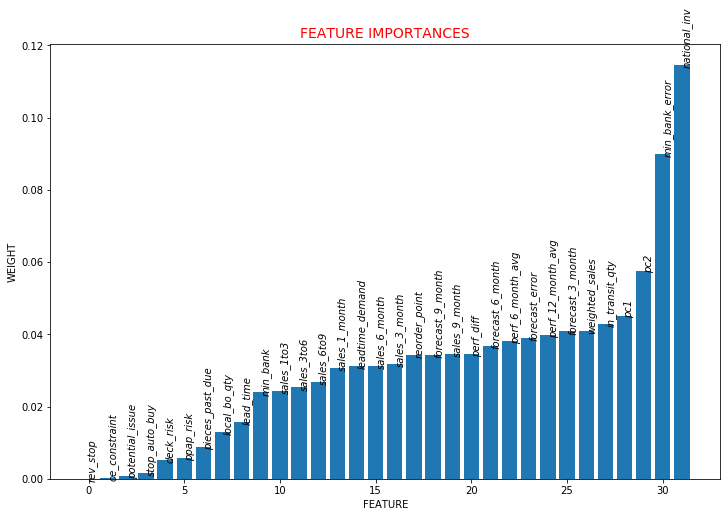

In [190]:
#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
rf_feat_imp = dict(zip(train_df.columns,np.round(clf_rf.feature_importances_,4)))
rf_feat_imp = {k: v for k, v in sorted(rf_feat_imp.items(), key=lambda item: item[1])}
model_interpretabiltiy(train_df,test_pred,rf_feat_imp)

<font color = 'green'>
<b>
    <i>

- As expected training ensemble Random forest has improved the ROC-AUC, PR-AUC and f1 scores significantly, ROC is 0.965, PR-score is 0.394 and f1-score on +ve points is 0.27 on test data. 
        
        
- The no.of false positives has decreased significantly which inturn improved the precision on the data, but the recall has decreased significantly compared to that of a single decision tree model.
  
        
- Model seems to work well on negative class datapoints with high scores on all the preformance metrics.
        
        
- Features current inventory and min_bank_error appears to be most important in classifying backorderes and non-backorders. 

<h3>3.2. Applying Random Forest on binned data </h3>

BEST-PARAMS:::	 {'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 15, 'n_estimators': 200}
BEST-SCORE:::	 0.9525808532224183
Train ROC-AUC score for best alpha-value:: 0.992 

Test ROC-AUC score for best alpha-value:: 0.956 


Train PR-AUC score for best alpha-value::  0.722
Test PR-AUC score for best alpha-value::  0.317


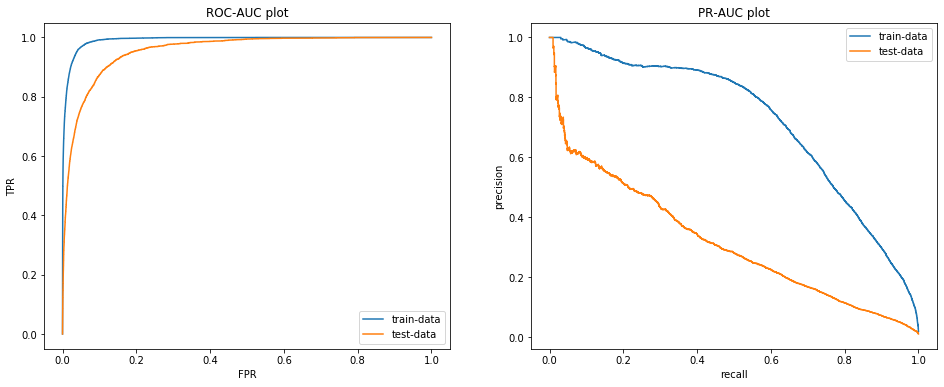

the maximum value of tpr*(1-fpr) 0.9198995924021256 for threshold 0.011


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    627216
           1       0.17      0.97      0.29      6550

    accuracy                           0.95    633766
   macro avg       0.58      0.96      0.63    633766
weighted avg       0.99      0.95      0.97    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    268808
           1       0.13      0.78      0.22      2807

    accuracy                           0.94    271615
   macro avg       0.56      0.86      0.59    271615
weighted avg       0.99      0.94      0.96    271615


			##### TRAIN CONFUSION MATRIX #####


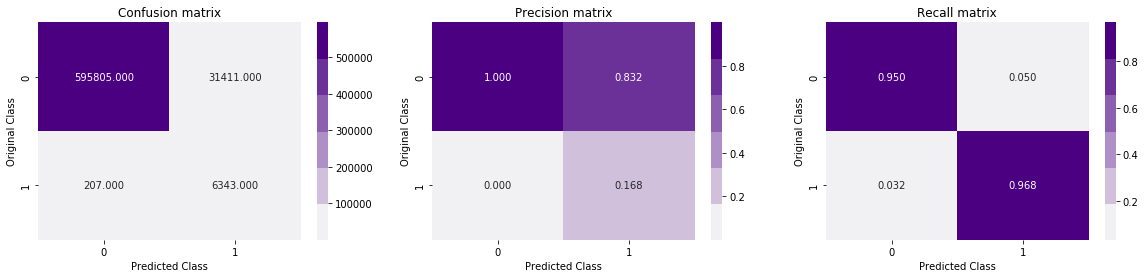

			##### TEST CONFUSION MATRIX #####


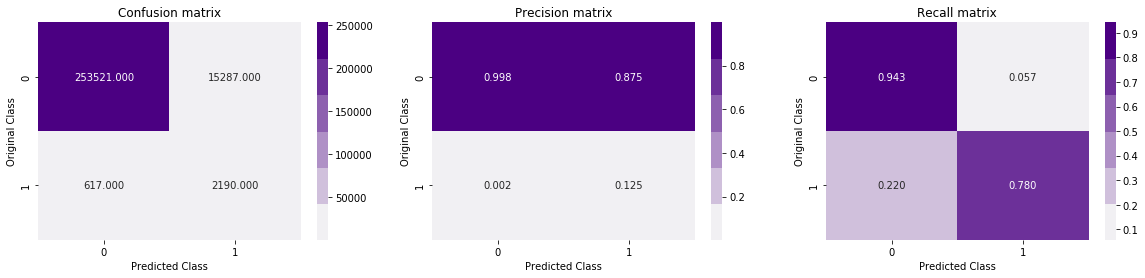

CPU times: user 29min, sys: 1.72 s, total: 29min 1s
Wall time: 1h 37min 54s


In [191]:
%%time

best_params = gridSearch(train_df_binned,RandomForestClassifier(),{'n_estimators':[10,50,100,200],'max_depth':[1, 5, 10,15],\
          'class_weight':[{0:0.1,1:0.9},{0:0.3,1:0.7},{0:0.2,1:0.8}]\
         })


clf_rf = RandomForestClassifier(n_estimators= best_params['n_estimators'],max_depth=best_params['max_depth'],class_weight=best_params['class_weight'])
clf_rf.fit(train_df_binned,y_train)
calib_clf_rf = CalibratedClassifierCV(clf_rf,method="sigmoid")
calib_clf_rf.fit(train_df_binned, y_train)

train_pred = calib_clf_rf.predict_proba(train_df_binned)
test_pred = calib_clf_rf.predict_proba(test_df_binned)

plot_AUC(train_pred,test_pred)

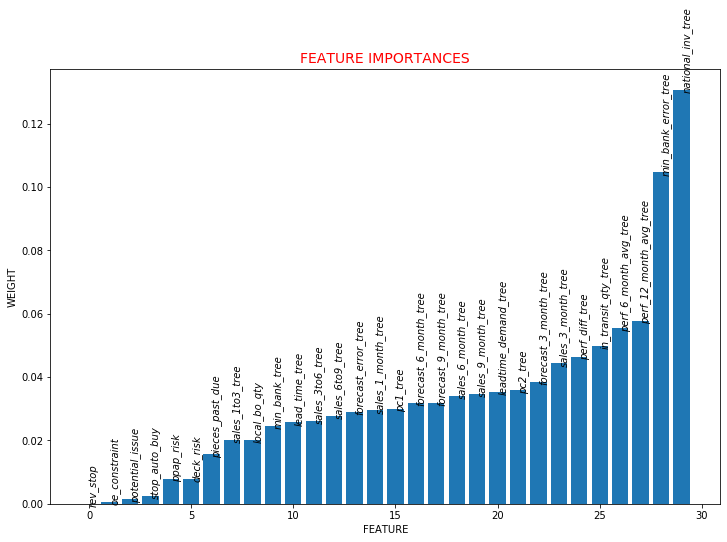

In [192]:
#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
rf_feat_imp = dict(zip(train_df_binned.columns,np.round(clf_rf.feature_importances_,4)))
rf_feat_imp = {k: v for k, v in sorted(rf_feat_imp.items(), key=lambda item: item[1])}
model_interpretabiltiy(train_df_binned,test_pred,rf_feat_imp)

<font color='green' >
    <b>
        <i>
            
- Training Random forest on binned data did not improve the AUC scores,preicsion but decreased them with noticeable decrease in PR-AUC, but the Recall is better than that of non-binned data.
            
            
- Binning data doesn't seem to be useful for tree based models in classifying backorders and non-backorders.
            
            
- Features min_bank_error and current inventory seems to be important classifying backorders and non-backorders

<h2> 4. Training XGBoost on the data </h2>

<h3> 4.1 Training XGBoost on non-binned data</h3>

In [193]:
%%time
params = {
    'max_depth':[5,10,15,20],
    'min_child_weight':[10,20,30,50]
}

xgb_clf = XGBClassifier(n_estimators = 500,learning_rate = 0.1,objective='binary:logistic',early_stopping_rounds = 10)

Random_Search = RandomizedSearchCV(xgb_clf, params,n_iter = 8, cv=3,scoring='roc_auc', n_jobs=-1, verbose=5)
Random_Search.fit(train_df,y_train)
best_params = Random_Search.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 228.3min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed: 368.1min remaining: 33.5min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 393.6min finished


CPU times: user 31min 28s, sys: 1.4 s, total: 31min 29s
Wall time: 7h 5min 24s


Train ROC-AUC score for best alpha-value:: 0.996 

Test ROC-AUC score for best alpha-value:: 0.966 


Train PR-AUC score for best alpha-value::  0.881
Test PR-AUC score for best alpha-value::  0.446


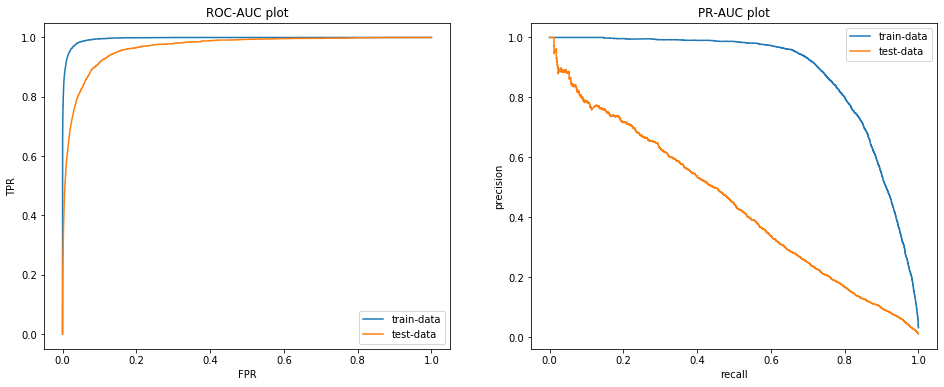

the maximum value of tpr*(1-fpr) 0.9420820921767263 for threshold 0.009


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    627216
           1       0.22      0.98      0.36      6550

    accuracy                           0.96    633766
   macro avg       0.61      0.97      0.67    633766
weighted avg       0.99      0.96      0.98    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    268808
           1       0.17      0.79      0.28      2807

    accuracy                           0.96    271615
   macro avg       0.59      0.88      0.63    271615
weighted avg       0.99      0.96      0.97    271615


			##### TRAIN CONFUSION MATRIX #####


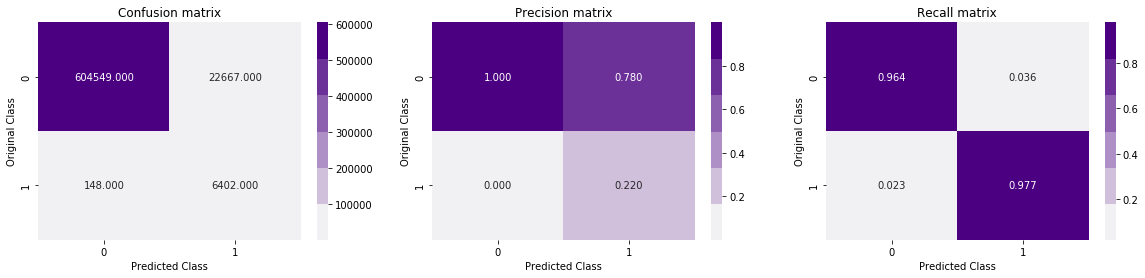

			##### TEST CONFUSION MATRIX #####


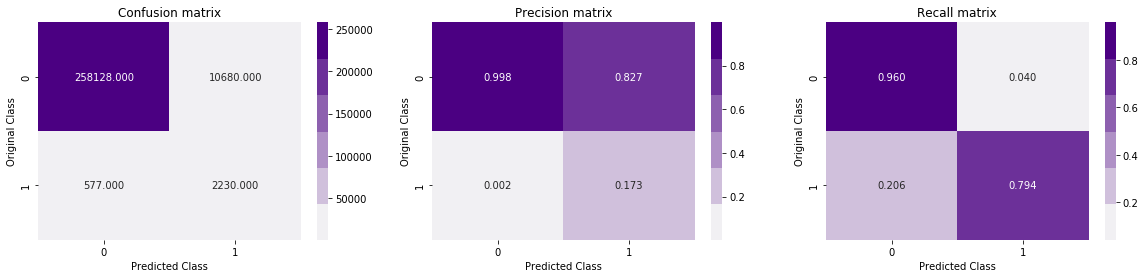

CPU times: user 2h 39min 44s, sys: 3.26 s, total: 2h 39min 47s
Wall time: 2h 42min 34s


In [194]:
%%time
xgb_clf_non_binned = XGBClassifier(n_estimators= 500,learning_rate = 0.1,\
                                 objective='binary:logistic',early_stopping_rounds = 10,eval_metric = 'auc',\
                                 max_depth=10,min_child_weight=10,sample_weight=[0.2,0.8],subsample = 0.8)
xgb_clf_non_binned.fit(train_df,y_train)
calib_clf_xgb = CalibratedClassifierCV(xgb_clf_non_binned,method="sigmoid")
calib_clf_xgb.fit(train_df, y_train)

train_pred = calib_clf_xgb.predict_proba(train_df)
test_pred = calib_clf_xgb.predict_proba(test_df)


plot_AUC(train_pred,test_pred)

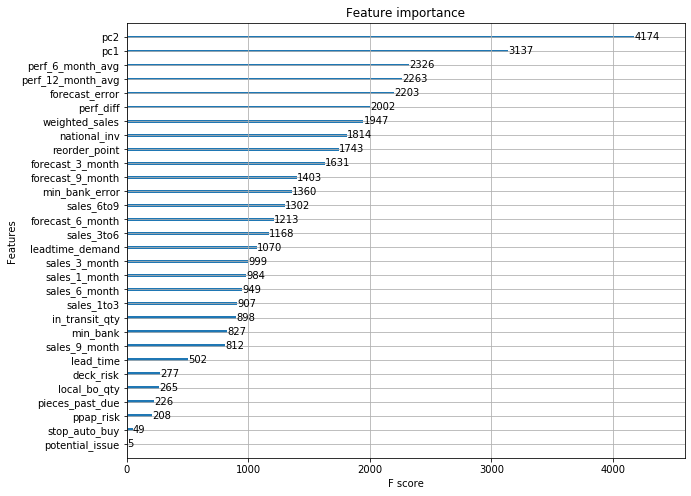

In [235]:
from xgboost import plot_importance

ax = plot_importance(xgb_clf_non_binned)
ax.figure.set_size_inches(10,8)

<font color = 'green'>
    <b>
        <i>
            
- XGBoost gave the best ROC-AUC and PR-AUC scores so far compared to the other models trained on the data, ROC-AUC is 0.966 and PR-AUC is 0.446. 
            
            
- There isn't much improvement from random forest in terms of ROC score but PR-AUC score has improved siginificantly. Recall and F1-score of +ve datapoints on the data are also better than random forest.
            
            
- PCA features seem to be the most important features for the model in classifying backorders and non-backorders.

<h3> 4.2 Training XGBoost on binned data</h3>

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 138.8min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed: 264.9min remaining: 24.1min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 280.3min finished


Train ROC-AUC score for best alpha-value:: 0.999 

Test ROC-AUC score for best alpha-value:: 0.96 


Train PR-AUC score for best alpha-value::  0.971
Test PR-AUC score for best alpha-value::  0.41


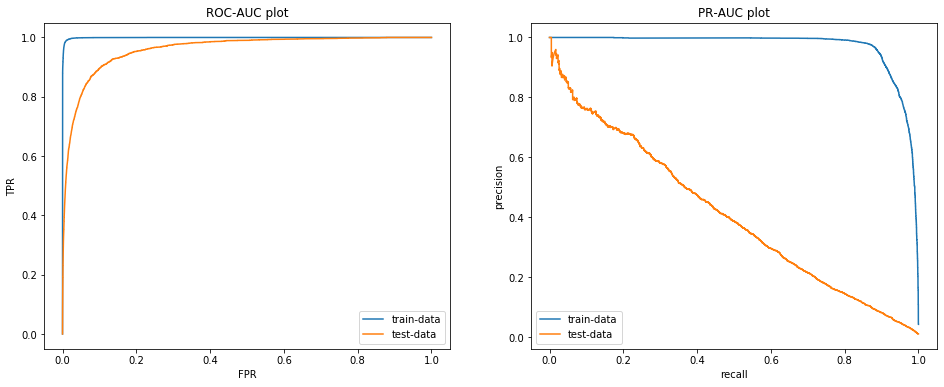

the maximum value of tpr*(1-fpr) 0.9798664341207997 for threshold 0.016


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    627216
           1       0.50      0.99      0.67      6550

    accuracy                           0.99    633766
   macro avg       0.75      0.99      0.83    633766
weighted avg       0.99      0.99      0.99    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    268808
           1       0.29      0.61      0.39      2807

    accuracy                           0.98    271615
   macro avg       0.64      0.80      0.69    271615
weighted avg       0.99      0.98      0.98    271615


			##### TRAIN CONFUSION MATRIX #####


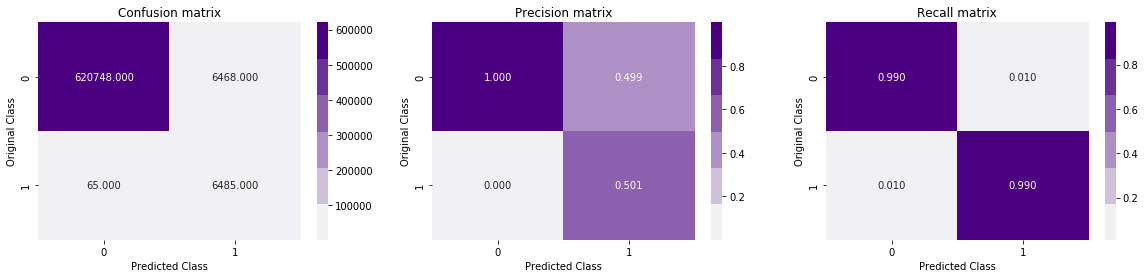

			##### TEST CONFUSION MATRIX #####


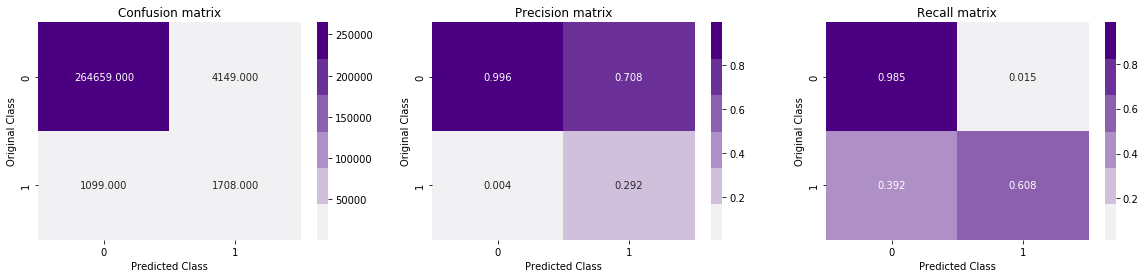

CPU times: user 3h 49min 33s, sys: 5.18 s, total: 3h 49min 38s
Wall time: 8h 34min 47s


In [195]:
%%time
params = {
    'max_depth':[5,10,15,20],
    'min_child_weight':[10,20,30,50]
}

xgb_clf = XGBClassifier(n_estimators = 500,learning_rate = 0.1,objective='binary:logistic',early_stopping_rounds = 10)

Random_Search = RandomizedSearchCV(xgb_clf, params,n_iter = 8, cv=3,scoring='roc_auc', n_jobs=-1, verbose=5)
Random_Search.fit(train_df_binned,y_train)
best_params = Random_Search.best_params_

xgb_clf_binned = XGBClassifier(n_estimators= 500,learning_rate = 0.1,\
                                 objective='binary:logistic',early_stopping_rounds = 10,eval_metric = 'auc',\
                                 max_depth = best_params['max_depth'],min_child_weight = best_params['min_child_weight'],sample_weight=[0.2,0.8],subsample = 0.8)
xgb_clf_binned.fit(train_df_binned,y_train)
calib_clf_xgb = CalibratedClassifierCV(xgb_clf_binned,method="sigmoid")
calib_clf_xgb.fit(train_df_binned, y_train)

train_pred = calib_clf_xgb.predict_proba(train_df_binned)
test_pred = calib_clf_xgb.predict_proba(test_df_binned)


plot_AUC(train_pred,test_pred)

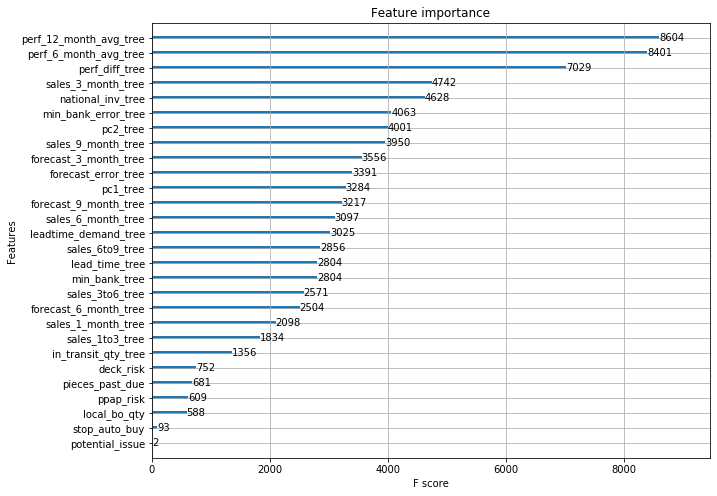

In [236]:
ax = plot_importance(xgb_clf_binned)
ax.figure.set_size_inches(10,8)

<font color = 'green'>
    <i>
        <b>
            
- Binning data seems to be not useful for any models because training XGBoost on binned data has lower AUC scores and f1-scores compared to model trained on non-binned data. Only Precision score improved but there is a significan decrease in recall.
            
            
- PCA features are not the important features in case of binnedd data, performance features seem to be the important features for classifying backorders.

<h1>5. Handling class Imbalance </h1>

<b>
    
    
- As observed from the EDA, data is extremely imbalanced with very less percentage of datapoints belongnig to positive class, training ML models with out considering this imbalance problem much gave very good AUC scores. So, if we use resampling techniques and make the class disstribution balanced, scores of the models might improve much further.
    
    
- From the above models we observed that ensembels gave the best AUC scores among all the models especially XGBoost , so training models XGBoost and RandomForest on resampled data might improve the performance, also training models EasyEnsemble,BalanceRandomForest might also classify backorders with high AUC scores.
    
    

<h3> Resampling Data</h3>

In [206]:
X = train_df
y = y_train

#resampling data
#----------------

#oversampling
over = RandomOverSampler()

#undersampling
under = RandomUnderSampler()

X_over, y_over = over.fit_resample(X, y)
X_under, y_under = under.fit_resample(X, y)

In [207]:
X_over.shape,X.shape
y_over.value_counts(),y_under.value_counts()

(1    627216
 0    627216
 Name: went_on_backorder, dtype: int64,
 1    6550
 0    6550
 Name: went_on_backorder, dtype: int64)

### 5.1.1 Training RandomForest on oversampled data

In [220]:
%%time

clf_rf = RandomForestClassifier(n_estimators= 200,max_depth=15,class_weight= {0: 0.3, 1: 0.7})
clf_rf.fit(X_over,y_over)
calib_clf_rf = CalibratedClassifierCV(clf_rf,method="sigmoid")
calib_clf_rf.fit(X_over, y_over)

train_pred = calib_clf_rf.predict_proba(X_over)
test_pred = calib_clf_rf.predict_proba(test_df)

CPU times: user 1h 2min 39s, sys: 17.5 s, total: 1h 2min 57s
Wall time: 1h 5min 28s


Train ROC-AUC score for best alpha-value:: 0.992 

Test ROC-AUC score for best alpha-value:: 0.952 


Train PR-AUC score for best alpha-value::  0.99
Test PR-AUC score for best alpha-value::  0.243


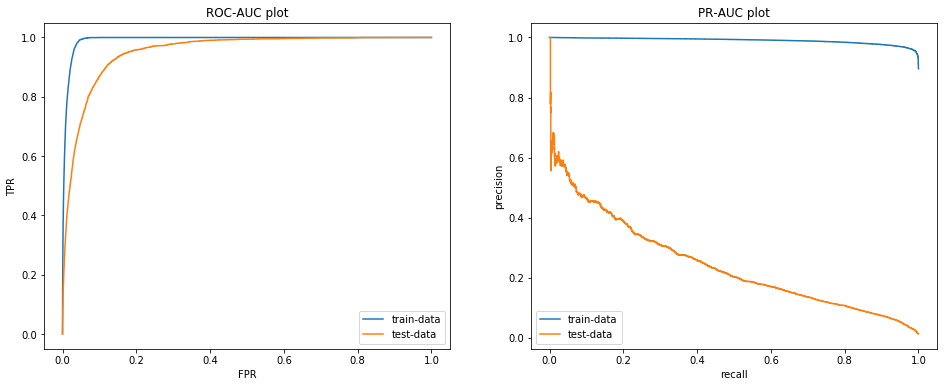

the maximum value of tpr*(1-fpr) 0.9455053997845309 for threshold 0.488


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    627216
           1       0.96      0.99      0.97    627216

    accuracy                           0.97   1254432
   macro avg       0.97      0.97      0.97   1254432
weighted avg       0.97      0.97      0.97   1254432



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    268808
           1       0.13      0.70      0.23      2807

    accuracy                           0.95    271615
   macro avg       0.57      0.83      0.60    271615
weighted avg       0.99      0.95      0.97    271615


			##### TRAIN CONFUSION MATRIX #####


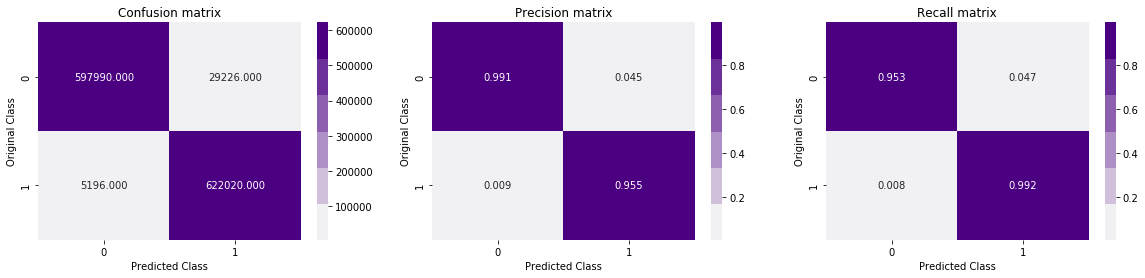

			##### TEST CONFUSION MATRIX #####


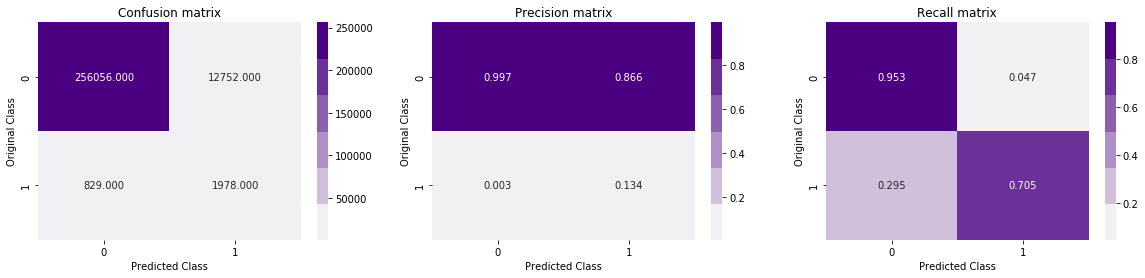

In [221]:
plot_AUC(train_pred,test_pred,y_over)

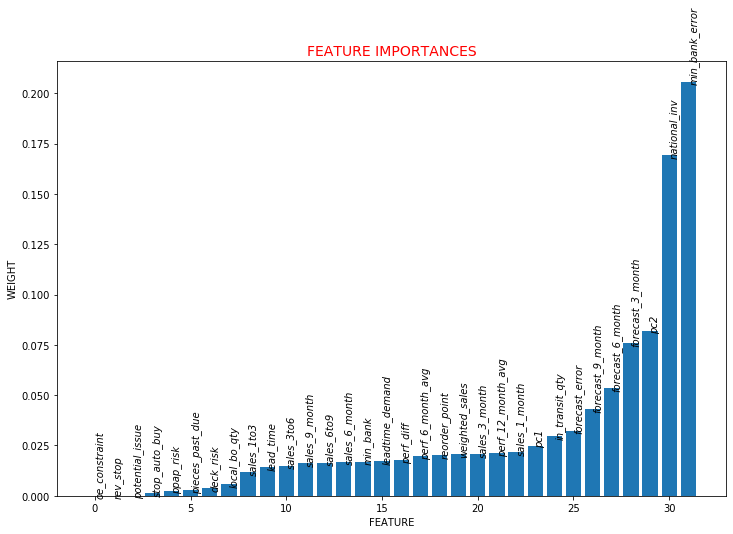

In [222]:
#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
rf_feat_imp = dict(zip(train_df.columns,np.round(clf_rf.feature_importances_,4)))
rf_feat_imp = {k: v for k, v in sorted(rf_feat_imp.items(), key=lambda item: item[1])}
model_interpretabiltiy(train_df,test_pred,rf_feat_imp)

### 5.1.2 Training  RandomForest on undersampled data

In [ ]:
%%time

clf_rf = RandomForestClassifier(n_estimators= 200,max_depth=15,class_weight= {0: 0.3, 1: 0.7})
clf_rf.fit(X_under,y_under)
calib_clf_rf = CalibratedClassifierCV(clf_rf,method="sigmoid")
calib_clf_rf.fit(X_under, y_under)

train_pred = calib_clf_rf.predict_proba(X_under)
test_pred = calib_clf_rf.predict_proba(test_df)


Train ROC-AUC score for best alpha-value:: 0.995 

Test ROC-AUC score for best alpha-value:: 0.948 


Train PR-AUC score for best alpha-value::  0.995
Test PR-AUC score for best alpha-value::  0.209


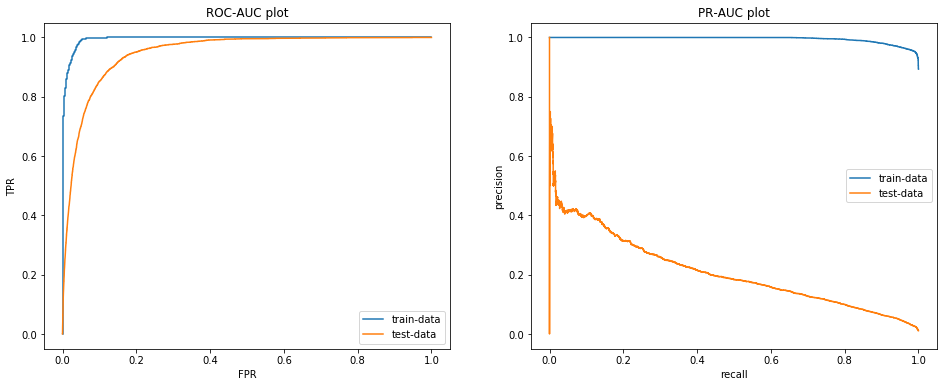

the maximum value of tpr*(1-fpr) 0.9415550375852223 for threshold 0.553


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      6550
           1       0.95      0.99      0.97      6550

    accuracy                           0.97     13100
   macro avg       0.97      0.97      0.97     13100
weighted avg       0.97      0.97      0.97     13100



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    268808
           1       0.07      0.89      0.13      2807

    accuracy                           0.87    271615
   macro avg       0.53      0.88      0.53    271615
weighted avg       0.99      0.87      0.92    271615


			##### TRAIN CONFUSION MATRIX #####


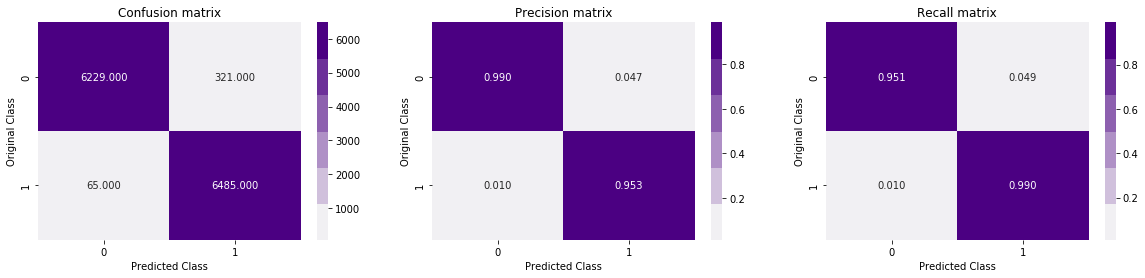

			##### TEST CONFUSION MATRIX #####


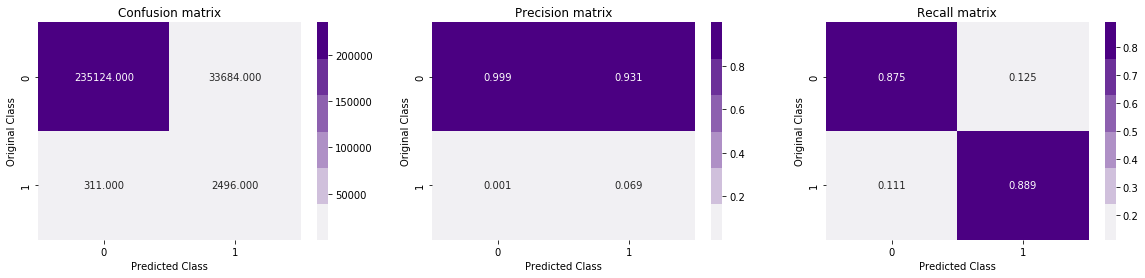

In [218]:
plot_AUC(train_pred,test_pred,y_under)

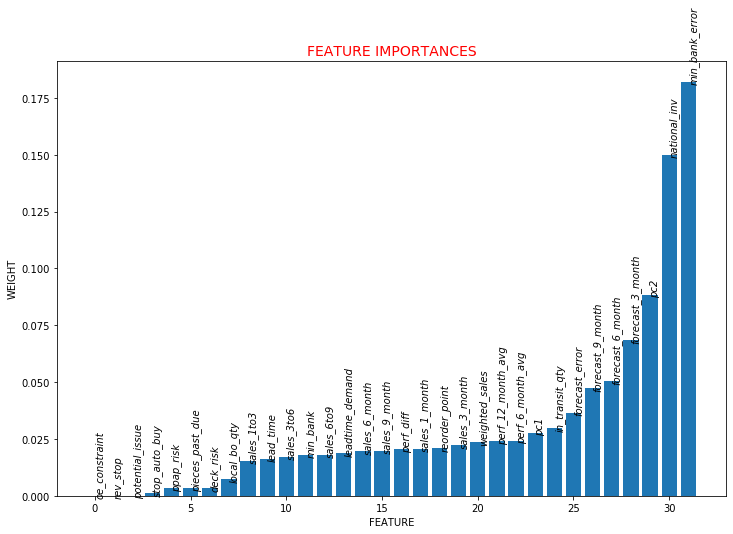

In [219]:
#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
rf_feat_imp = dict(zip(train_df.columns,np.round(clf_rf.feature_importances_,4)))
rf_feat_imp = {k: v for k, v in sorted(rf_feat_imp.items(), key=lambda item: item[1])}
model_interpretabiltiy(train_df,test_pred,rf_feat_imp)

<font color = 'green'>
    <i>
        <b>

- Training Random Forest on oversampled data gave an AUC of 0.952 and PR-AUC of  0.243 which are lower scores compared to Random forest trained on data that is not resampled.


- Precision, recall and F1-scores also decreased when trained on oversampled data. Oversampling of data doesn't seem to be much useful than training Random Forest on regular data.
            
            
- Training Random FOrest on under sampled data also didn't improve the AUC and f1 scores. Roc-auc is 0.948, Pr-auc is 0.20 and f1 score is 0.13. Precision has decreased significantly compared to oversampled data, recall has improved significantly which gave the best recall score among all the models trained so far. 
            
           

<h3> 5.2.1 Training XGBoost on Oversampled data </h3>

Train ROC-AUC score for best alpha-value:: 1.0 

Test ROC-AUC score for best alpha-value:: 0.969 


Train PR-AUC score for best alpha-value::  1.0
Test PR-AUC score for best alpha-value::  0.499


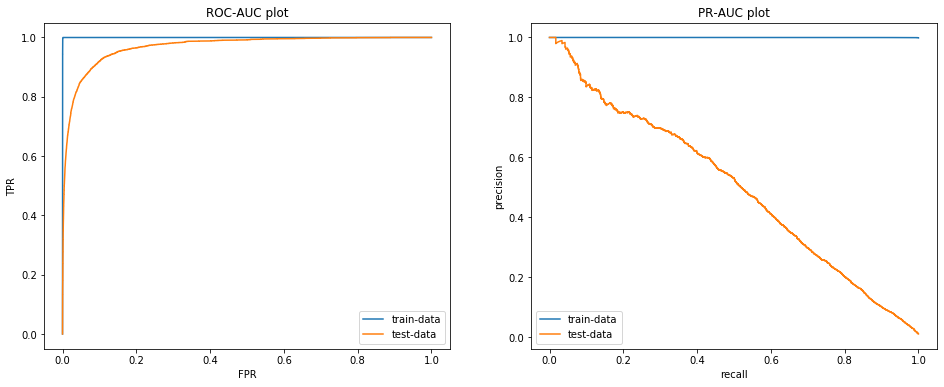

the maximum value of tpr*(1-fpr) 0.9987677229331556 for threshold 0.552


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    627216
           1       1.00      1.00      1.00    627216

    accuracy                           1.00   1254432
   macro avg       1.00      1.00      1.00   1254432
weighted avg       1.00      1.00      1.00   1254432



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    268808
           1       0.63      0.39      0.48      2807

    accuracy                           0.99    271615
   macro avg       0.81      0.69      0.74    271615
weighted avg       0.99      0.99      0.99    271615


			##### TRAIN CONFUSION MATRIX #####


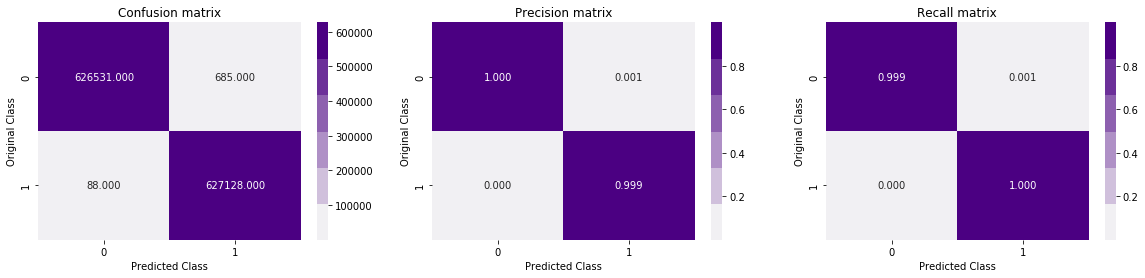

			##### TEST CONFUSION MATRIX #####


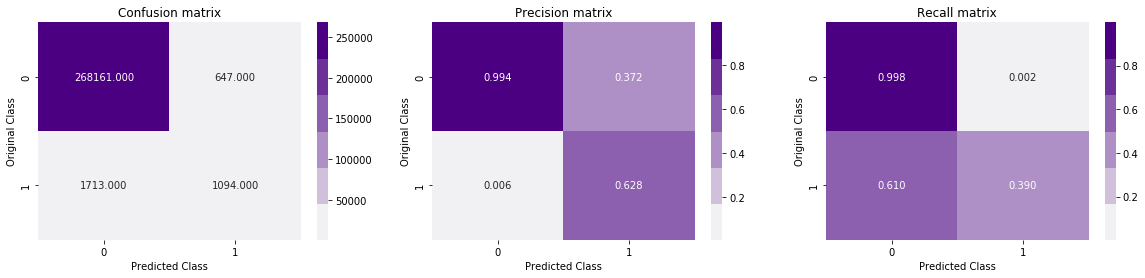

CPU times: user 6h 31min 57s, sys: 45.2 s, total: 6h 32min 43s
Wall time: 6h 47min 3s


In [223]:
%%time
clf_xgb_over = XGBClassifier(n_estimators= 500,learning_rate = 0.1,\
                                 objective='binary:logistic',early_stopping_rounds = 10,eval_metric = 'auc',\
                                 max_depth=10,min_child_weight=10,sample_weight=[0.2,0.8],subsample = 0.8)
clf_xgb_over.fit(X_over,y_over)
calib_clf_xgb = CalibratedClassifierCV(clf_xgb_over,method="sigmoid")
calib_clf_xgb.fit(X_over,y_over)

train_pred = calib_clf_xgb.predict_proba(X_over)
test_pred = calib_clf_xgb.predict_proba(test_df)


plot_AUC(train_pred,test_pred,y=y_over)

<h3> 5.2.2 Training XGBoost on Undersampled data </h3>

Train ROC-AUC score for best alpha-value:: 0.999 

Test ROC-AUC score for best alpha-value:: 0.948 


Train PR-AUC score for best alpha-value::  0.999
Test PR-AUC score for best alpha-value::  0.195


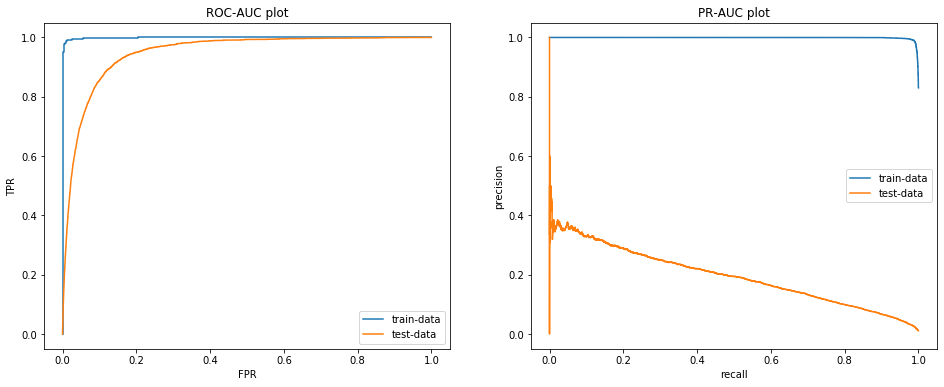

the maximum value of tpr*(1-fpr) 0.9782845288736087 for threshold 0.524


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6550
           1       0.99      0.99      0.99      6550

    accuracy                           0.99     13100
   macro avg       0.99      0.99      0.99     13100
weighted avg       0.99      0.99      0.99     13100



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    268808
           1       0.07      0.89      0.13      2807

    accuracy                           0.87    271615
   macro avg       0.53      0.88      0.53    271615
weighted avg       0.99      0.87      0.92    271615


			##### TRAIN CONFUSION MATRIX #####


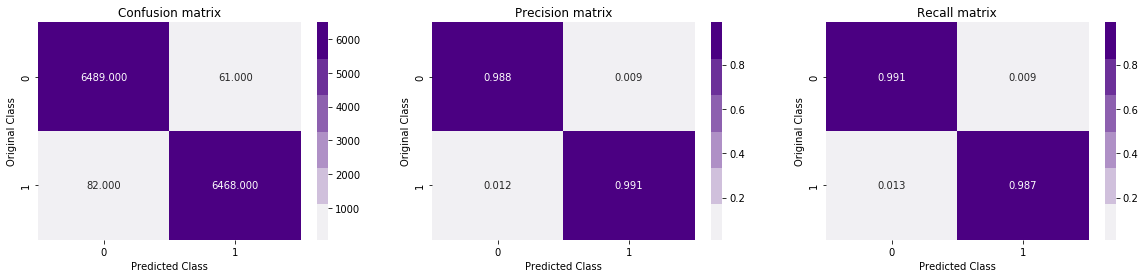

			##### TEST CONFUSION MATRIX #####


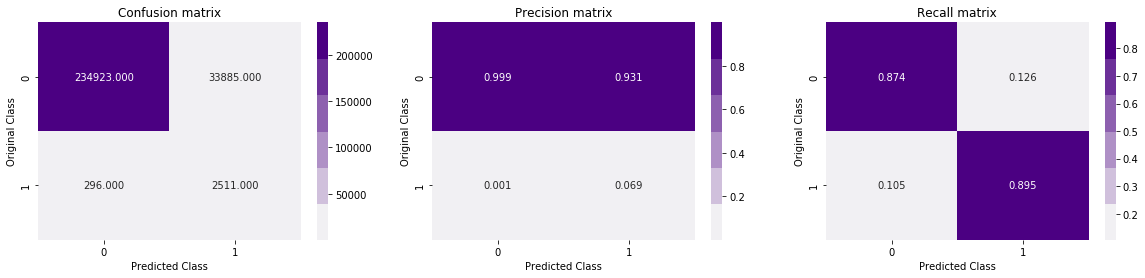

CPU times: user 3min 1s, sys: 444 ms, total: 3min 1s
Wall time: 4min 3s


In [224]:
%%time
clf_xgb = XGBClassifier(n_estimators= 500,learning_rate = 0.1,\
                                 objective='binary:logistic',early_stopping_rounds = 10,eval_metric = 'auc',\
                                 max_depth=10,min_child_weight=10,sample_weight=[0.2,0.8],subsample = 0.8)
clf_xgb.fit(X_under,y_under)
calib_clf_xgb = CalibratedClassifierCV(clf_xgb,method="sigmoid")
calib_clf_xgb.fit(X_under,y_under)

train_pred = calib_clf_xgb.predict_proba(X_under)
test_pred = calib_clf_xgb.predict_proba(test_df)


plot_AUC(train_pred,test_pred,y=y_under)

<font color = 'green'>
    <i>
        <b>
            
- Training XGBoost on oversampled data has given the best AUC,f1 and precision scores but the recall has dropped so much, recall of XGBoost on unsampled data is 0.79 while for oversampled data recall is 0.39.

            
- Training XGBoost on undersampled data didnt improve the AUC scores but recall has improved significantly, recall is ~0.9 when trained on undersampled data.

<h3> 5.3 Applying BalancedRandomForestClassifier on data </h3>

<h4> Hyperparamter Tuning </h4>

BEST-PARAMS:::	 {'n_estimators': 500}
BEST-SCORE:::	 0.9493709939997076
Train ROC-AUC score for best alpha-value:: 0.98 

Test ROC-AUC score for best alpha-value:: 0.953 


Train PR-AUC score for best alpha-value::  0.473
Test PR-AUC score for best alpha-value::  0.274


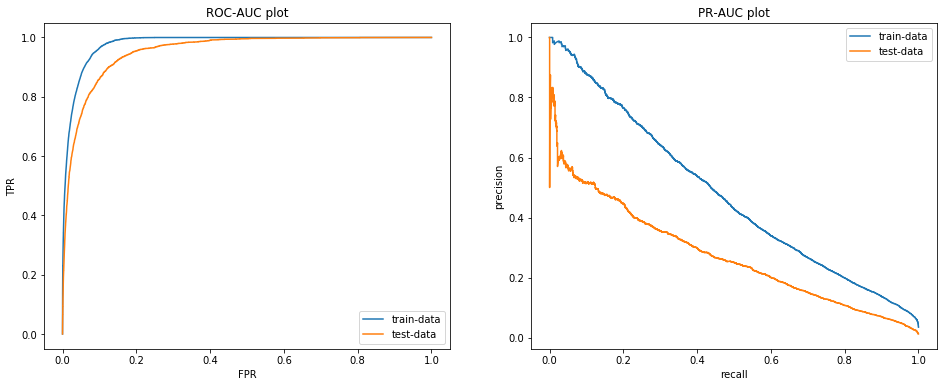

the maximum value of tpr*(1-fpr) 0.8683059227340946 for threshold 0.015


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    627216
           1       0.09      0.97      0.16      6550

    accuracy                           0.89    633766
   macro avg       0.54      0.93      0.55    633766
weighted avg       0.99      0.89      0.94    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    268808
           1       0.08      0.87      0.14      2807

    accuracy                           0.89    271615
   macro avg       0.54      0.88      0.54    271615
weighted avg       0.99      0.89      0.93    271615


			##### TRAIN CONFUSION MATRIX #####


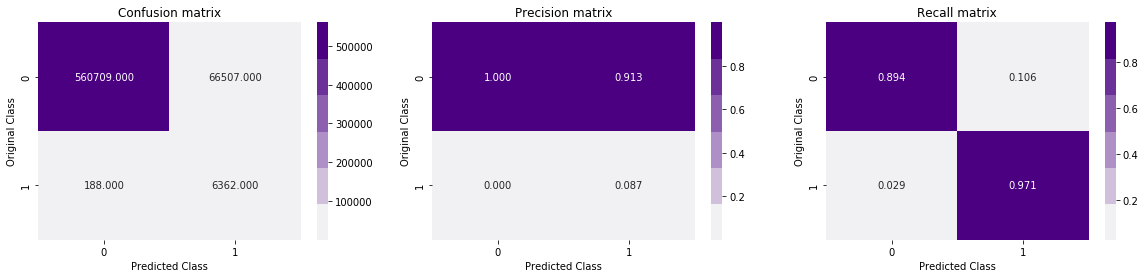

			##### TEST CONFUSION MATRIX #####


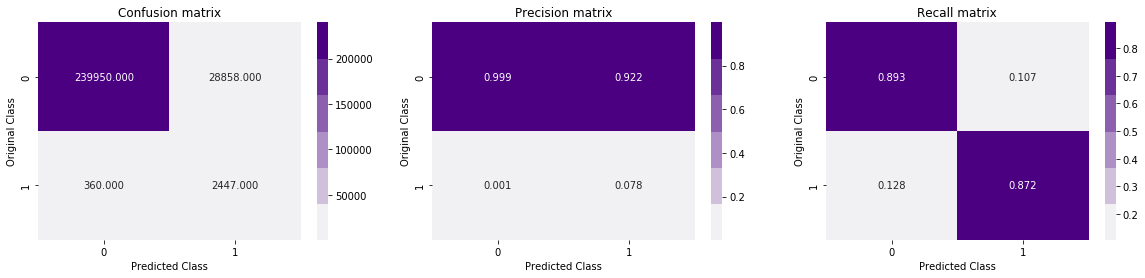

CPU times: user 20min 36s, sys: 16.1 s, total: 20min 52s
Wall time: 41min 51s


In [226]:
%%time
best_params = gridSearch(train_df,BalancedRandomForestClassifier(),{'n_estimators' : [10,50,100,300,500,1000]})


clf_brf = BalancedRandomForestClassifier(n_estimators = best_params['n_estimators'],n_jobs=-1)
clf_brf.fit(train_df, y_train)
calib_clf = CalibratedClassifierCV(clf_brf,method="sigmoid")
calib_clf.fit(train_df, y_train)

train_pred = calib_clf.predict_proba(train_df)
test_pred = calib_clf.predict_proba(test_df)


plot_AUC(train_pred,test_pred)

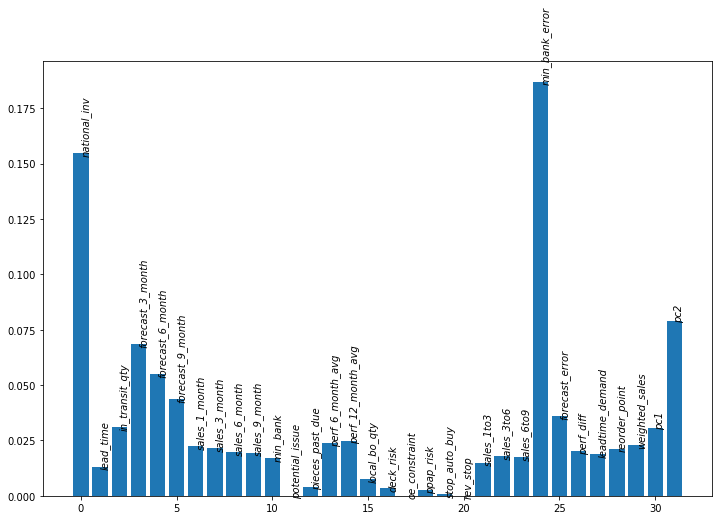

In [228]:
brf_feat_imp = dict(zip(train_df.columns,clf_brf.feature_importances_))
plt.figure(figsize=(12,8))
plt.bar(range(len(train_df.columns)),brf_feat_imp.values())
for i, feat,imp in zip(range(len(brf_feat_imp.keys())),brf_feat_imp.keys(),brf_feat_imp.values()):
    plt.text(i ,imp  , str(feat), color='k', fontstyle='italic',rotation = 90)
plt.show()

<font color = 'green'>
    <b>
        <i>

- Balanced Random Forest gave good AUC scores and recall score but the f1-score and precision is very low which is due to false positives predictied by the model. Training Balanced random FOrest on the data gave the following performance scores,
 
            ROC-AUC  : 0.953, 
            PR-AUC   : 0.274,
            Precision: 0.08,
            recall   : 0.87,
            f1-score : 0.14
 
            
- min_bank_error,CUrrent inventory and pc2 appears to be the main features for the model.

### Training EasyEnsemble on the data

BEST-PARAMS:::	 {'n_estimators': 100}
BEST-SCORE:::	 0.9295828861283787
Train ROC-AUC score for best alpha-value:: 0.933 

Test ROC-AUC score for best alpha-value:: 0.93 


Train PR-AUC score for best alpha-value::  0.166
Test PR-AUC score for best alpha-value::  0.175


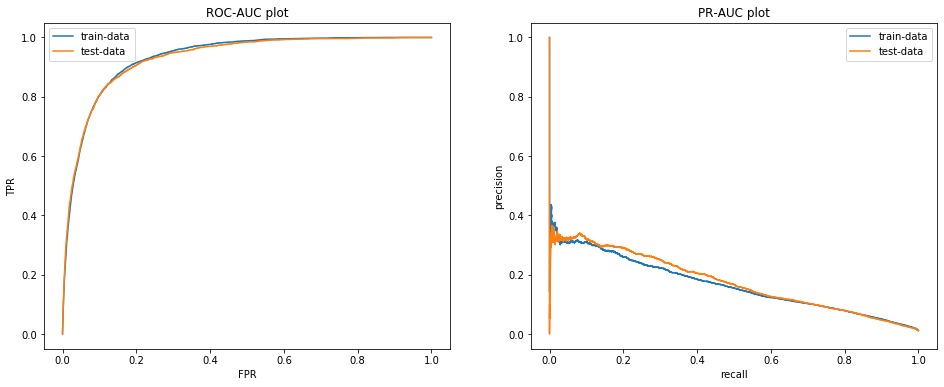

the maximum value of tpr*(1-fpr) 0.744863885112761 for threshold 0.013


------------------------------
Classification Report:Train
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    627216
           1       0.06      0.87      0.11      6550

    accuracy                           0.85    633766
   macro avg       0.53      0.86      0.51    633766
weighted avg       0.99      0.85      0.91    633766



------------------------------
Classification Report:Test
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    268808
           1       0.06      0.86      0.11      2807

    accuracy                           0.85    271615
   macro avg       0.53      0.86      0.51    271615
weighted avg       0.99      0.85      0.91    271615


			##### TRAIN CONFUSION MATRIX #####


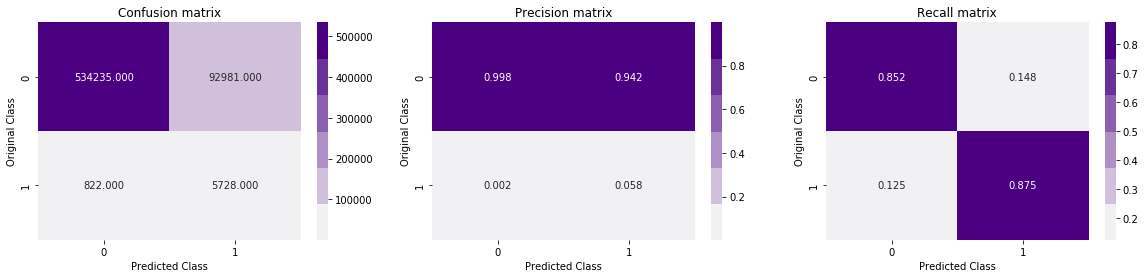

			##### TEST CONFUSION MATRIX #####


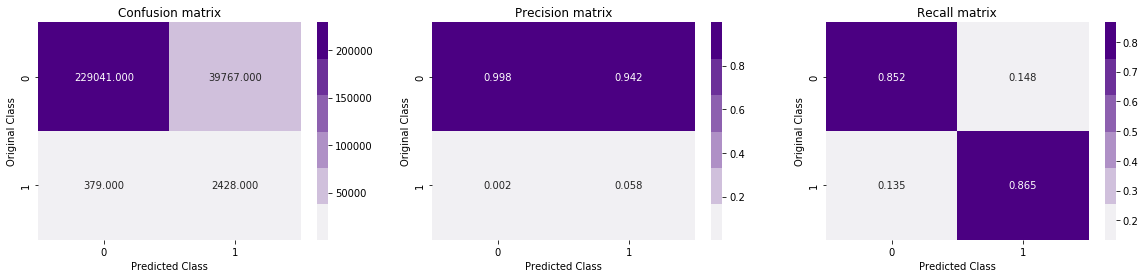

CPU times: user 3min 15s, sys: 6.48 s, total: 3min 22s
Wall time: 4h 42min 36s


In [229]:
%%time
best_params = gridSearch(train_df,EasyEnsembleClassifier(),{'n_estimators' : [100,300,500]})


clf_eec = EasyEnsembleClassifier(n_estimators = best_params['n_estimators'],n_jobs=-1)
clf_eec.fit(train_df, y_train)
calib_clf = CalibratedClassifierCV(clf_eec,method="sigmoid")
calib_clf.fit(train_df, y_train)

train_pred = calib_clf.predict_proba(train_df)
test_pred = calib_clf.predict_proba(test_df)



plot_AUC(train_pred,test_pred)

<font color = 'green'>
    <b>
        <i>

- Easy Ensemble classisfier gave the following performance scores on the data,

        ROC-AUC : 0.93
        PR-AUC  : 0.175
        precision : 0.06
        recall : 0.86
        f1-score : 0.11
        
- Easy ensemble yeilded a good AUC and recall scores but precision and f1-score are too low, false positives seems to be a problem for Easy Ensembles too.



In [240]:
#https://stackoverflow.com/questions/43583847/python-pretty-table-with-color-output

table = PrettyTable(['MODEL','ROC-AUC','PR-AUC','PRECISION','RECALL','+VE F1-SCORE'])

score_dict = {'Logit':[0.90,0.09,0.05,0.87,0.09],\
'Logit_binned':[0.89,0.09,0.05,0.80,0.09],\
'DT':[0.93,0.21,0.07,0.86,0.12],\
'DT_binned':[0.92,0.18,0.06,0.84,0.12],\
'RF':[0.96,0.39,0.17,0.77,0.27],\
'RF_binned':[0.95,0.32,0.13,0.78,0.22],\
'XGB':[0.96,0.44,0.17,0.79,0.28],\
'XGB_binned':[0.96,0.41,0.29,0.61,0.39],\
'RF_oversampled':[0.95,0.24,0.13,0.70,0.23],\
'RF_undersampled':[0.95,0.21,0.07,0.89,0.13],\
'XGB_oversampled':[0.97,0.5,0.63,0.39,0.48],\
'XGB_undersampled':[0.95,0.19,0.07,0.89,0.13],\
'Balanced_RF':[0.95,0.27,0.08,0.87,0.14],\
'EasyEnsemble':[0.93,0.17,0.06,0.86,0.09]}

for model,scores in score_dict.items():
    row = [model]
    scores = ["\033[1;32m%s\033[0m"%score for score in scores]
    row.extend(scores)
    table.add_row(row)

print(table)

+------------------+---------+--------+-----------+--------+--------------+
|      MODEL       | ROC-AUC | PR-AUC | PRECISION | RECALL | +VE F1-SCORE |
+------------------+---------+--------+-----------+--------+--------------+
|      Logit       |   0.9   |  0.09  |    0.05   |  0.87  |     0.09     |
|   Logit_binned   |   0.89  |  0.09  |    0.05   |  0.8   |     0.09     |
|        DT        |   0.93  |  0.21  |    0.07   |  0.86  |     0.12     |
|    DT_binned     |   0.92  |  0.18  |    0.06   |  0.84  |     0.12     |
|        RF        |   0.96  |  0.39  |    0.17   |  0.77  |     0.27     |
|    RF_binned     |   0.95  |  0.32  |    0.13   |  0.78  |     0.22     |
|       XGB        |   0.96  |  0.44  |    0.17   |  0.79  |     0.28     |
|    XGB_binned    |   0.96  |  0.41  |    0.29   |  0.61  |     0.39     |
|  RF_oversampled  |   0.95  |  0.24  |    0.13   |  0.7   |     0.23     |
| RF_undersampled  |   0.95  |  0.21  |    0.07   |  0.89  |     0.13     |
| XGB_oversa

## Observations:
------

<font color = 'darkgreen'>
    <i>
        <b>

- All the models performance is very good even though there is a problem of class imbalance, almost all the models ROC-AUC is above 0.9. Even though all the models PR-AUC is not a high as ROC-AUC, PR-AUC is considerably good for a model with extreme imbalance.

            
- Binning continuos data didn't seem to be useful for any of the model, all the models that are trained on binned data had a reduced performance when compared to the performance on non-binned data.
            
            
- Resampling data also didn't improve the models AUC & f1-scores but slightly reduced the scores, but the recall on the data has significantly improved for models Random Forest and XGBoost when trained on undersampled data. Recall for both the models improved from 0.79 to 0.89.
            
            
- None of the categorical features seem to be useful for almost all the models in classifying the backorders, Custom created features forecast_error,min_bank_error,performance_diff and PCA features have been very useful for most of the models in classifying backorders. 
            
            
            
- All the models have a problem of predicting false positives which inturn resulted in low f1 and PR-AUC scores. For the models Random Forest and XGBoost the no.of false positives seem to be less than other models, considering the total Negative points in the data false positive points predicted by these models are not that high.


## Choosing the best ML model for the problem:
----
<font color = 'black'> 
    <i>
       <b>
           
- For a Business to improve its revenue it should be able to predict as many backorders as possible and also need to be accurate in predicting backorders, predicting non-backorders as backorders could be a problem sometimes depending on the storage space available in the warehouse.
  
           
- So, considering the above point we need to choose a model that has high AUC score and at the same time high recall and high precision values. Almost all of the ensemble models trained have given AUC scores above 0.95, so we need to choose one among the ensembles that has high recall and precision.
           
           
- Among all of the ensembles Random Forest trained on undersampled data and XGBoost trained on undersampled data gave the highest recall rate but none of them gave a good precision score. The reason for bad precision score is due to both models predicting some false positives. 
           
           
- If we observe the confusion matrices of both the models false positives are ~33800 among 268808 total negatives which is 12% of the total negative points. Due to extreme class imbalance of the data we got very low precision scores even though the total no.of false positives are not that significant. 
           

           
- So we could choose one among Random forest or XGBoost that are trained on undersampled data for predicting the backorders in realtime. Since, Random forest has slightly higher PR-AUC score we choose Random Forest for predicting backorders.
    
    
   
            
       
       
            